In [1]:
import os
import subprocess
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import flopy

import warnings



#sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'font.size': 11})

In [2]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
bins_abspth = os.path.abspath(bins_pth)

Name of calibrated model:

In [3]:
ml_name = 'hagfors_1'
result_ws = os.path.join('..', '2022_01_22_ok_1week_out')
pest_ws = os.path.join(result_ws, 'pest')
mngr_ml = os.path.join(result_ws, 'runmodel', 'model')
observations_pth = os.path.join('..', 'data', 'observations') # Measured data (field obs)
os.listdir(result_ws)

['agent', 'pest', 'runmodel']

Edit MF6 output control to save a cell budget file (including specific discharge):

In [4]:
sim_mngr = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), mngr_ml)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ghb...
    loading package obs...
    loading package sfr...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package oc...
  loading ims package hagfors_1...


In [323]:
gwf_mngr = sim_mngr.get_model(ml_name)

In [6]:
gwf_mngr.remove_package('oc')

In [7]:
oc = flopy.mf6.ModflowGwfoc(
    gwf_mngr,
    pname='oc',
    budget_filerecord='{}.cbb'.format(ml_name),
    head_filerecord='{}.hds'.format(ml_name),
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    printrecord=[('HEAD', 'FIRST'), ('HEAD', 'LAST'), ('BUDGET', 'LAST')]
)

In [8]:
# Enable saving of specific discharge
gwf_mngr.npf.save_specific_discharge = True

In [9]:
# Rewrite simulation files
sim_mngr.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package hagfors_1...
  writing model hagfors_1...
    writing model name file...
    writing package disv...
    writing package rch_ts...
    writing package rch...
    writing package sto...
    writing package npf...
    writing package ic...
    writing package sfr_ts...
    writing package sfr_ts...
    writing package sfr_ts...
    writing package sfr_obs...
    writing package sfr...
    writing package gwf_obs...
    writing package ghb_ts...
    writing package ghb...
    writing package oc...


Use PARREP to replace model with parameters with optimal parameters:

In [11]:
p = subprocess.run([
    'parrep',
    'calib1-wt-cov-linux.par.10',
    'calib1-wt-cov-linux.pst',
    'calib-parrep.pst',
    '0'
], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)


PARREP Version 17.3. Watermark Numerical Computing.

Reading parameter value file calib1-wt-cov-linux.par.10 ----->
Data for 2065 parameters read from file calib1-wt-cov-linux.par.10.

Reading file calib1-wt-cov-linux.pst and writing file calib-parrep.pst ----->
File calib-parrep.pst written ok.



Calculate a jacobian matrix for the optimized-parameter pestfile. **This takes 4 - 5 minutes!**.

In [12]:
p = subprocess.run(['i64jco2jco', 'calib1-wt-cov-linux.pst', 'calib-parrep.pst',], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)

 JCO2JCO Version 17.3. Watermark Numerical Computing.
 - file calib1-wt-cov-linux.pst read ok.
 - file calib1-wt-cov-linux.jco read ok.
 - file calib-parrep.pst read ok.
 - file calib-parrep.jco written ok.

 different value from that of parameter of same name in first PEST control file.



Edit the `.pst` file for use in a Windows environment:

In [13]:
with open(os.path.join(pest_ws, 'calib-parrep.pst'), 'r') as file:
    pstfile = file.readlines()

In [14]:
# Locate model command line
model_cmdline = pstfile.index('* model command line\n') + 1
pstfile[model_cmdline] = 'runmodel.bat\n'

In [15]:
pstfile = [i.replace('/', '\\') for i in pstfile]

In [16]:
model_io = pstfile.index('* model command line\n') + 2

In [17]:
pstfile[model_io] = '* model input/output\n'

In [18]:
with open(os.path.join(pest_ws, 'calib-parrep.pst'), 'w') as file:
    for line in pstfile:
        file.write(line)

Copy Windows binaries:

In [19]:
copyfiles = ['agent_hp.exe', 'libiomp5md.dll', 'pest_hp_mkl.exe']

In [20]:
for file in copyfiles:
    shutil.copyfile(os.path.join(bins_pth, file), os.path.join(pest_ws, file))

Create an agent directory and create a copy:

In [6]:
agent_dir = os.path.join(result_ws ,'agent')
if os.path.exists(agent_dir):
    shutil.rmtree(agent_dir)
shutil.copytree(result_ws,agent_dir)
agent_pest_ws = os.path.join(agent_dir, 'pest')

Write run-scripts for both manager and agent:

In [7]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [8]:
write_script(os.path.join(pest_ws, 'start_manager.bat'), [
f'''
set PATH=%PATH%;{bins_abspth}
pest_hp_mkl calib-parrep.pst /h :4004
pause
'''
])

In [9]:
write_script(os.path.join(agent_pest_ws, 'start_agent.bat'), [
f'''
set PATH=%PATH%;{bins_abspth}
agent_hp calib-parrep.pst /h %computername%:4004
pause
'''
])

Manually run `start_manager.bat` in pest_ws  
Manually run `start_agent.bat` in agent_pest_ws  

Once the batch files have been run to completion, import the results:

In [324]:
agent_ml, ml_name = os.path.join(agent_dir, 'runmodel', 'model'), 'hagfors_1'

In [325]:
sim_agent = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), agent_ml)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ghb...


MFDataException: An error occurred in model "hagfors_1" package "ghb_ts". The error occurred while loading package file in the "load" method.
Additional Information:
(1) File C:\Users\nat12nho\Documents\Development\repos\hagfors_gwm\notebooks\..\2022_01_22_ok_1week_out\agent\runmodel\model\ghb_new.ts of type ts could not be opened.

In [326]:
gwf_agent = sim_agent.get_model(ml_name)

In [13]:
sim_agent.run_simulation()

FloPy is using the following executable to run the model: ..\bins\win\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 01/22/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Jan 22 2022 02:25:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor t

    Solving:  Stress period:     2    Time step:   126
    Solving:  Stress period:     2    Time step:   127
    Solving:  Stress period:     2    Time step:   128
    Solving:  Stress period:     2    Time step:   129
    Solving:  Stress period:     2    Time step:   130
    Solving:  Stress period:     2    Time step:   131
    Solving:  Stress period:     2    Time step:   132
    Solving:  Stress period:     2    Time step:   133
    Solving:  Stress period:     2    Time step:   134
    Solving:  Stress period:     2    Time step:   135
    Solving:  Stress period:     2    Time step:   136
    Solving:  Stress period:     2    Time step:   137
    Solving:  Stress period:     2    Time step:   138
    Solving:  Stress period:     2    Time step:   139
    Solving:  Stress period:     2    Time step:   140
    Solving:  Stress period:     2    Time step:   141
    Solving:  Stress period:     2    Time step:   142
    Solving:  Stress period:     2    Time step:   143
    Solvin

(True, [])

In [14]:
# field measurement positions
meas_pos = pd.read_csv(os.path.join(observations_pth, 'measurement_positions.csv'))

# objective function reduction
ofr = pd.read_csv(os.path.join(agent_pest_ws, 'calib1-wt-cov-linux.ofr'), skiprows=3, delim_whitespace=True)

# get the specific discharge from the cell budget file
cbb_file = os.path.join(agent_ml, f'{ml_name}.cbb')
cbb = flopy.utils.CellBudgetFile(cbb_file)
spdis = cbb.get_data(text="SPDIS")[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf_agent)

# get the head from the head file
head_file = os.path.join(agent_ml, f'{ml_name}.hds')
head = flopy.utils.HeadFile(head_file)
hdata = head.get_alldata()

In [15]:
ofr.round(2)

iteration  measurement  regularisation    heads   stage1    gage1  \
0           0      9000.00            0.00  1000.02  1000.00  1000.00   
1           1      3390.75          577.42   231.62   341.43   473.72   
2           2      2327.72         1254.87    47.37   262.36   262.47   
3           3      2211.20         1199.31    43.14   249.66   257.38   
4           4      2174.87         1442.79    39.64   246.82   259.70   
5           5      2139.90         1628.45    38.35   238.92   261.40   
6           6      2117.66         1915.04    38.86   235.54   261.02   
7           7      2086.90         3204.85    42.62   232.07   261.21   
8           8      2051.97         4454.35    40.69   229.54   263.98   
9           9      2006.16         7692.12    40.81   228.76   264.57   
10         10      2006.16         7692.12    40.81   228.76   264.57   
11         10      1976.88         8340.24    35.17   225.00   266.16   

      gage2  dh_hedstg  heads_d  stage1_d  gage1_d  gage2_d  pleak  
0   1000.00     999.99  1000.00   1000.00  1000.00  1000.00    0.0  
1    401.21     245.87   742.38    498.46   317.64   138.43    0.0  
2    152.82     221.95   683.17    395.85   211.48    90.27    0.0  
3    127.31     176.41   669.89    384.89   212.03    90.48    0.0  
4    115.52     169.32   660.11    381.59   211.62    90.55    0.0  
5    115.98     163.83   640.34    379.40   211.60    90.08    0.0  
6    113.60     158.63   631.40    376.36   212.10    90.18    0.0  
7    111.33     154.97   610.26    367.24   217.31    89.87    0.0  
8    111.49     150.80   581.63    368.85   215.26    89.73    0.0  
9    109.54     149.58   544.01    364.29   215.71    88.89    0.0  
10   109.54     149.58   544.01    364.29   215.71    88.89    0.0  
11   109.24     152.69   520.73    362.58   216.60    88.72    0.0

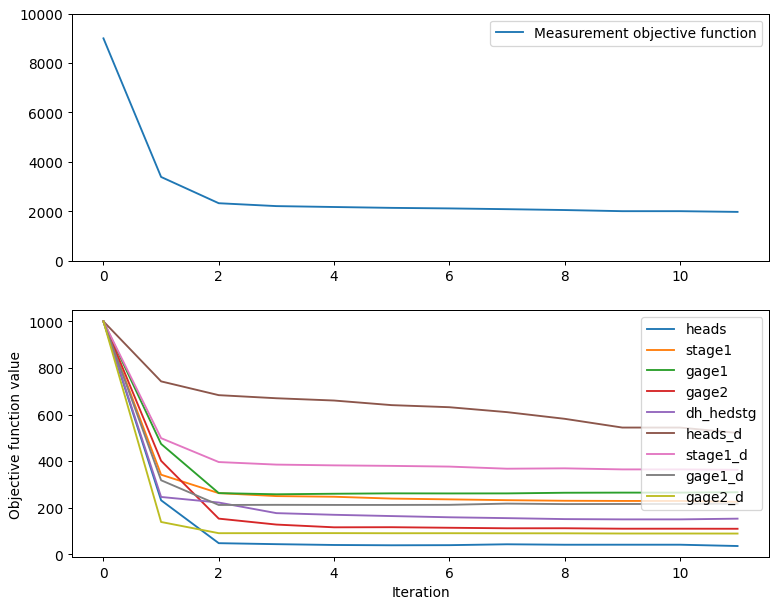

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), dpi=90)

axs[0].plot(ofr['measurement'], label='Measurement objective function')
axs[0].set_ylim([0, 10000])
axs[0].legend()

for col in ofr.columns:
    if col in ['measurement', 'iteration', 'regularisation', 'pleak']:
        continue
    else:
        axs[1].plot(ofr[col], label=col)
        axs[1].legend(fontsize=8)
        
    
plt.xlabel('Iteration')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

In [33]:
reifilename = 'calib1-wt-cov-linux.rei.10'

with open(os.path.join(pest_ws, reifilename), 'r') as file:
    reifile = file.readlines() #pestfile partial parameters

In [34]:
reifile = [i.replace('Cov. Mat.', 'covmat') for i in reifile]

In [35]:
with open(os.path.join(pest_ws, 'calib-parrep.rei'), 'w') as file:
    for line in reifile:
        file.write(line)

In [36]:
# Residuals
rei_df = pd.read_csv(os.path.join(pest_ws, 'calib-parrep.rei'), skiprows=7, delim_whitespace=True)
rei_df.columns = rei_df.columns.str.lower()

In [37]:
# Drop regularisation and prediction
rei_df = rei_df[~rei_df.group.str.contains('regul')]
rei_df

name  group  measured  modelled    residual     weight
0          b2-1_1  heads  137.0535  136.9914    0.062097  0.7582940
1          b2-1_2  heads  137.0488  136.9931    0.055681  0.7582940
2          b2-1_3  heads  137.0533  136.9948    0.058465  0.7582940
3          b2-1_4  heads  137.0538  137.0010    0.052762  0.7582940
4          b2-1_5  heads  137.0558  137.0100    0.045754  0.7582940
...           ...    ...       ...       ...         ...        ...
82199  lk-265_204  pleak -707.5909 -618.2534  -89.337490   0.000000
82200  lk-265_205  pleak -702.1789 -610.8109  -91.367980   0.000000
82201  lk-265_206  pleak -734.6429 -602.1054 -132.537500   0.000000
82202  lk-265_207  pleak -740.2785 -612.8721 -127.406400   0.000000
82203  lk-265_208  pleak -694.2779 -603.8205  -90.457390   0.000000

[82204 rows x 6 columns]

In [38]:
rei_df['sites'] = [i.split('_')[0] for i in rei_df.name]

In [39]:
rei_df.loc[rei_df['sites'] == 'b2-1']

name    group    measured    modelled  residual     weight sites
0          b2-1_1    heads  137.053500  136.991400  0.062097  0.7582940  b2-1
1          b2-1_2    heads  137.048800  136.993100  0.055681  0.7582940  b2-1
2          b2-1_3    heads  137.053300  136.994800  0.058465  0.7582940  b2-1
3          b2-1_4    heads  137.053800  137.001000  0.052762  0.7582940  b2-1
4          b2-1_5    heads  137.055800  137.010000  0.045754  0.7582940  b2-1
...           ...      ...         ...         ...       ...        ...   ...
15813  b2-1_d1056  heads_d   -0.129940    0.035629 -0.165569   3.039500  b2-1
15814  b2-1_d1057  heads_d   -0.128291    0.035741 -0.164032   3.039500  b2-1
15815  b2-1_d1058  heads_d   -0.129396    0.035852 -0.165248   3.039500  b2-1
15816  b2-1_d1059  heads_d   -0.126456    0.035964 -0.162420   3.039500  b2-1
15817  b2-1_d1060  heads_d   -0.123855    0.036075 -0.159930   3.039500  b2-1

[2119 rows x 7 columns]

In [40]:
rei_df.group.unique()

array(['heads', 'stage1', 'gage1', 'gage2', 'dh_hedstg', 'heads_d',
       'stage1_d', 'gage1_d', 'gage2_d', 'pleak'], dtype=object)

In [41]:
# Sites with measured head
heads_sites = rei_df.loc[rei_df['group'] == 'heads'].sites.unique()
stage1_sites = rei_df.loc[rei_df['group'] == 'stage1'].sites.unique()
dh_hedstg_sites = rei_df.loc[rei_df['group'] == 'dh_hedstg'].sites.unique()

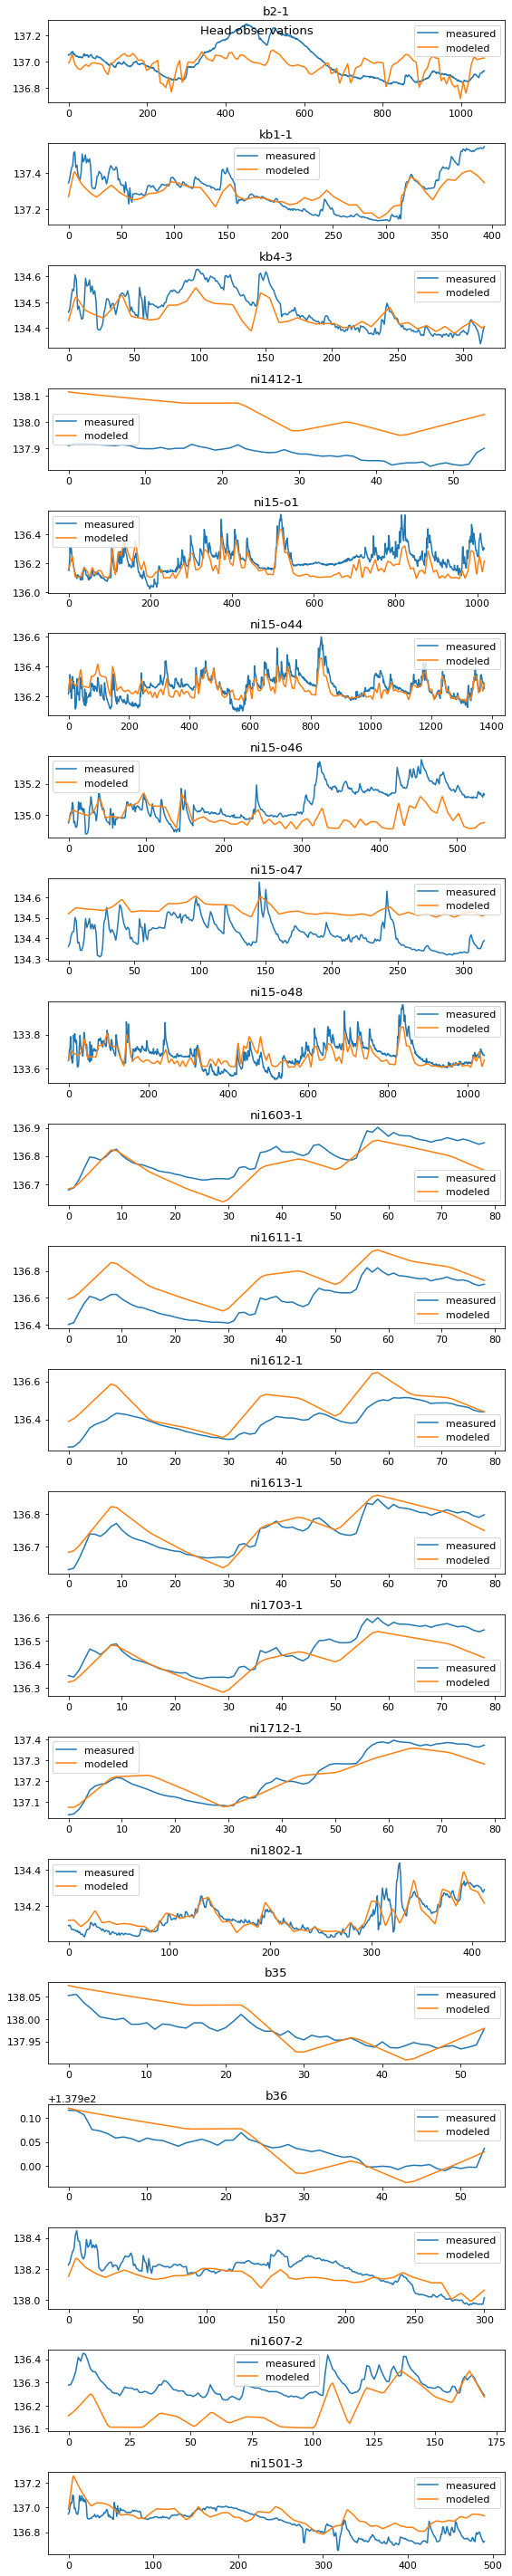

In [42]:
nsubplots = len(heads_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 40))
for i, site in enumerate(heads_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.suptitle('Head observations')
plt.tight_layout()

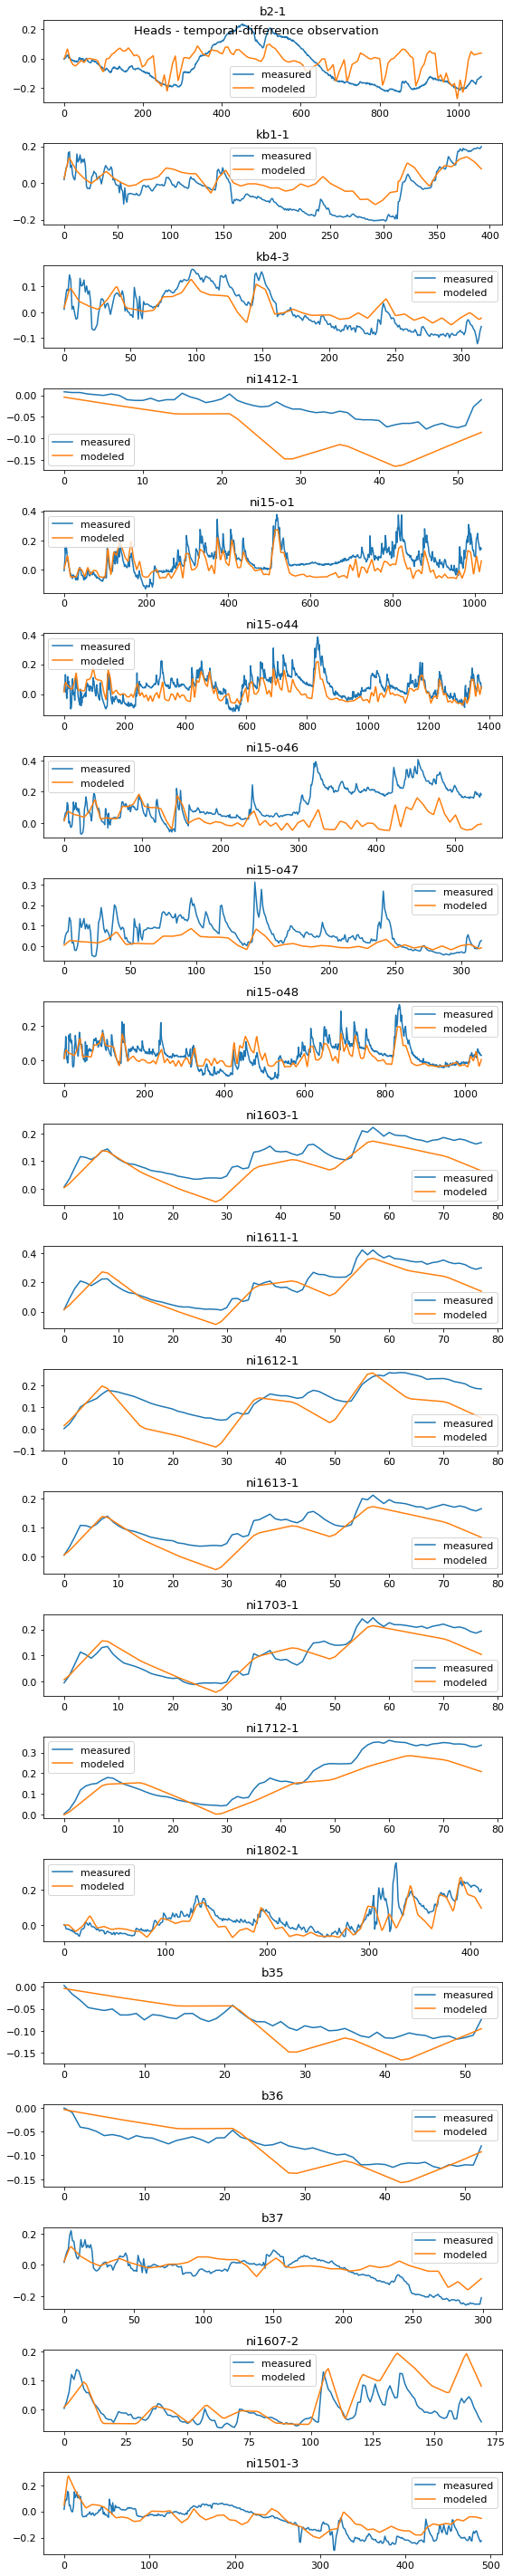

In [43]:
nsubplots = len(heads_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 40))
for i, site in enumerate(heads_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads_d')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads_d')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads_d')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.suptitle('Heads - temporal-difference observation')
plt.tight_layout()

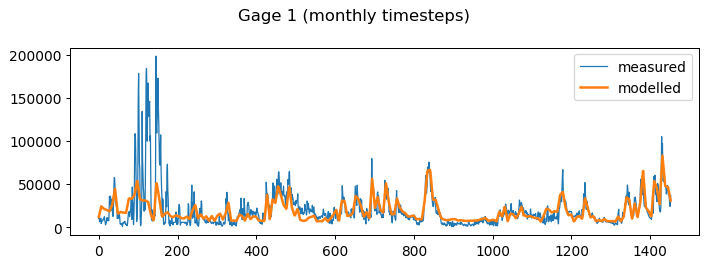

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=90)
x = [i for i in range(len(rei_df.loc[rei_df['group'] == 'gage1']))]
y_meas = rei_df.loc[rei_df['group'] == 'gage1']['measured']
y_comp = rei_df.loc[rei_df['group'] == 'gage1']['modelled']
plt.plot(x, y_meas, label='measured', lw=1)
plt.plot(x, y_comp, label='modelled', lw=2)

plt.legend()
plt.suptitle('Gage 1 (monthly timesteps)')
plt.tight_layout()
plt.show()

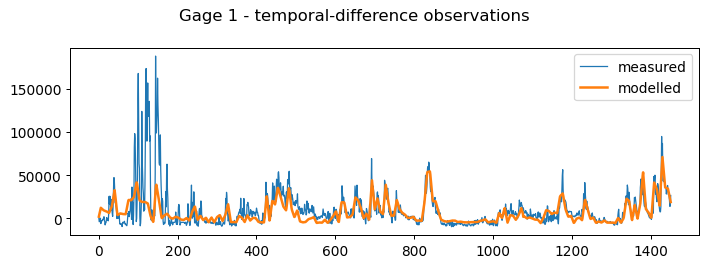

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=90)
x = [i for i in range(len(rei_df.loc[rei_df['group'] == 'gage1_d']))]
y_meas = rei_df.loc[rei_df['group'] == 'gage1_d']['measured']
y_comp = rei_df.loc[rei_df['group'] == 'gage1_d']['modelled']
plt.plot(x, y_meas, label='measured', lw=1)
plt.plot(x, y_comp, label='modelled', lw=2)

plt.legend()
plt.suptitle('Gage 1 - temporal-difference observations')
plt.tight_layout()
plt.show()

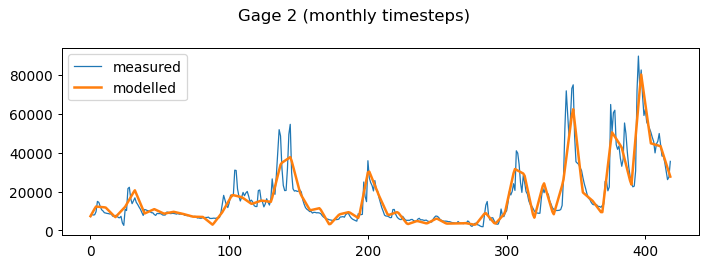

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=90)
x = [i for i in range(len(rei_df.loc[rei_df['group'] == 'gage2']))]
y_meas = rei_df.loc[rei_df['group'] == 'gage2']['measured']
y_comp = rei_df.loc[rei_df['group'] == 'gage2']['modelled']
plt.plot(x, y_meas, label='measured', lw=1)
plt.plot(x, y_comp, label='modelled', lw=2)

plt.legend()
plt.suptitle('Gage 2 (monthly timesteps)')
plt.tight_layout()
plt.show()

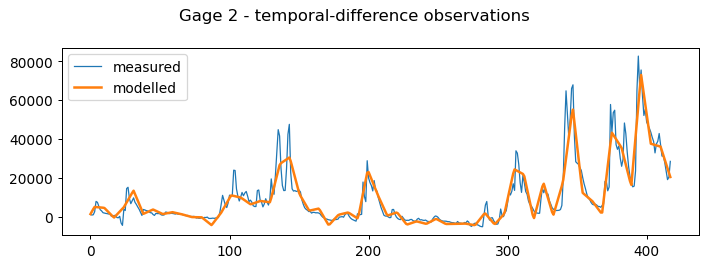

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=90)
x = [i for i in range(len(rei_df.loc[rei_df['group'] == 'gage2_d']))]
y_meas = rei_df.loc[rei_df['group'] == 'gage2_d']['measured']
y_comp = rei_df.loc[rei_df['group'] == 'gage2_d']['modelled']
plt.plot(x, y_meas, label='measured', lw=1)
plt.plot(x, y_comp, label='modelled', lw=2)

plt.legend()
plt.suptitle('Gage 2 - temporal-difference observations')
plt.tight_layout()
plt.show()

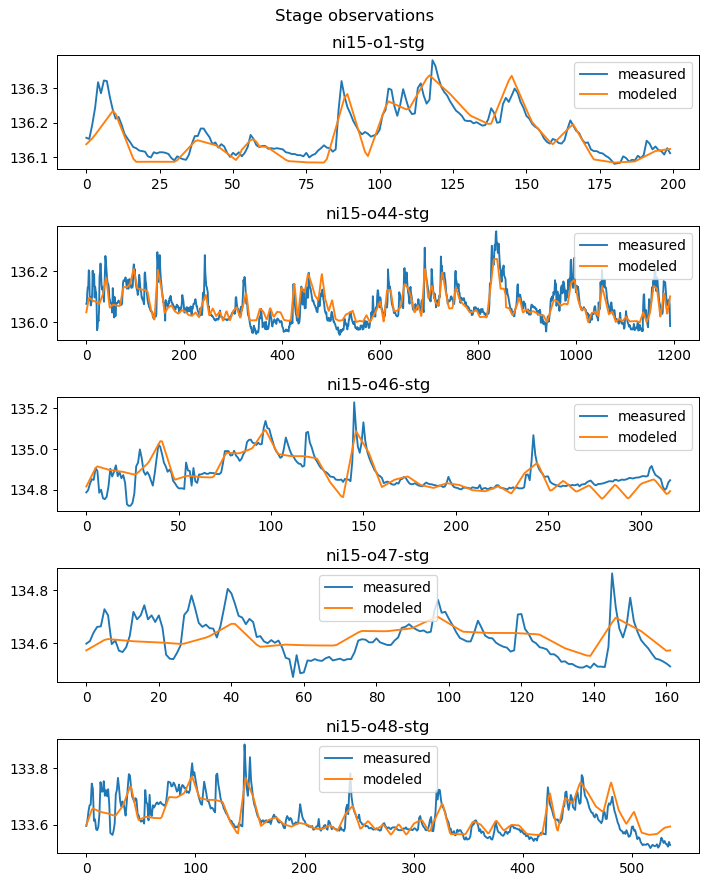

In [48]:
nsubplots = len(stage1_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 10), dpi=90)
for i, site in enumerate(stage1_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.suptitle('Stage observations')
plt.tight_layout()

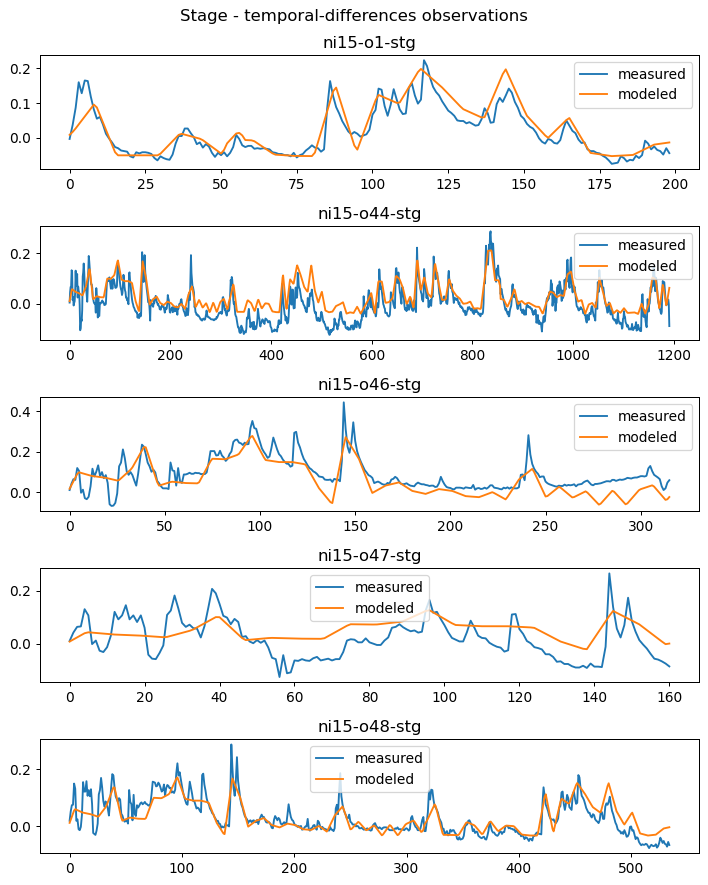

In [49]:
nsubplots = len(stage1_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 10), dpi=90)
for i, site in enumerate(stage1_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1_d')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1_d')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1_d')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.suptitle('Stage - temporal-differences observations')
plt.tight_layout()

In [50]:
rei_df.loc[rei_df['group'] == 'dh_hedstg']['measured']

12353    0.000000
12354   -0.003333
12355   -0.006666
12356   -0.010000
12357   -0.008334
           ...   
14754    0.020000
14755    0.020000
14756    0.021666
14757    0.031667
14758    0.030000
Name: measured, Length: 2406, dtype: float64

In [51]:
dh_hedstg_sites

array(['dh-ni15-o1', 'dh-ni15-o44', 'dh-ni15-o46', 'dh-ni15-o47',
       'dh-ni15-o48'], dtype=object)

In [52]:
rei_df.loc[rei_df['sites'] == 'dh-ni15-o44']

name      group  measured  modelled  residual    weight  \
12553     dh-ni15-o44_1  dh_hedstg  0.143083  0.199886 -0.056803  4.257670   
12554     dh-ni15-o44_2  dh_hedstg  0.157325  0.203912 -0.046587  4.257670   
12555     dh-ni15-o44_3  dh_hedstg  0.146309  0.207937 -0.061628  4.257670   
12556     dh-ni15-o44_4  dh_hedstg  0.145225  0.211963 -0.066738  4.257670   
12557     dh-ni15-o44_5  dh_hedstg  0.142141  0.215988 -0.073847  4.257670   
...                 ...        ...       ...       ...       ...       ...   
13739  dh-ni15-o44_1187  dh_hedstg  0.221530  0.202396  0.019134  4.257670   
13740  dh-ni15-o44_1188  dh_hedstg  0.210397  0.201336  0.009061  4.257670   
13741  dh-ni15-o44_1189  dh_hedstg  0.202814  0.200277  0.002537  4.257670   
13742  dh-ni15-o44_1190  dh_hedstg  0.182614  0.199218 -0.016604  4.257670   
13743  dh-ni15-o44_1191  dh_hedstg  0.182822  0.198159 -0.015337  4.257670   

             sites  
12553  dh-ni15-o44  
12554  dh-ni15-o44  
12555  dh-ni15-o44  
12556  dh-ni15-o44  
12557  dh-ni15-o44  
...            ...  
13739  dh-ni15-o44  
13740  dh-ni15-o44  
13741  dh-ni15-o44  
13742  dh-ni15-o44  
13743  dh-ni15-o44  

[1191 rows x 7 columns]

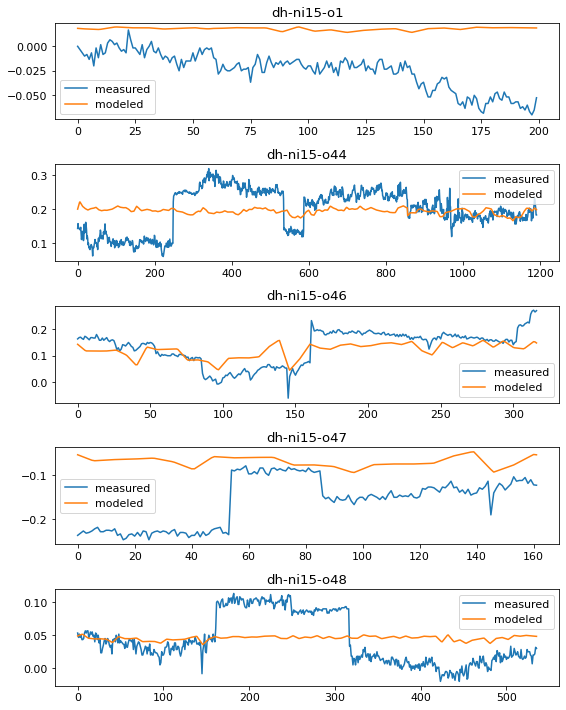

In [53]:
nsubplots = len(dh_hedstg_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 10))
for i, site in enumerate(dh_hedstg_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'dh_hedstg')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'dh_hedstg')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'dh_hedstg')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.tight_layout()

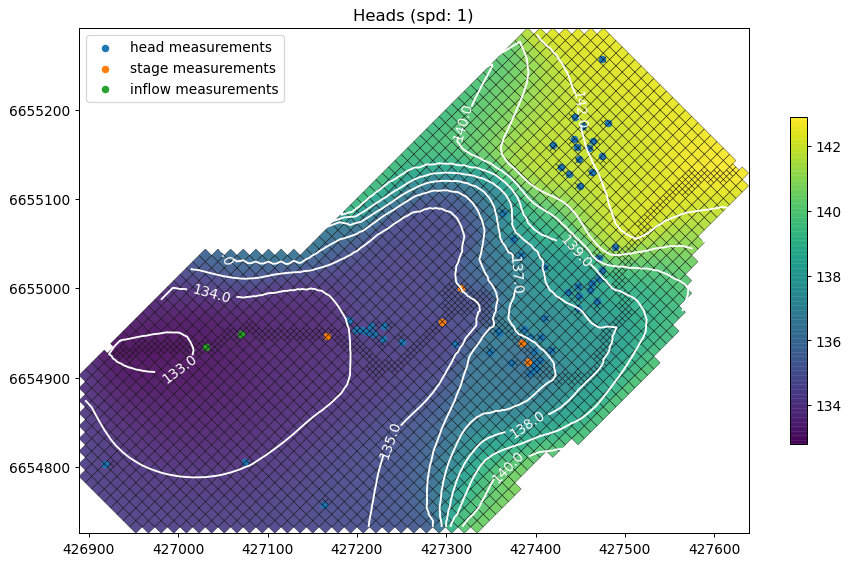

In [54]:
spd = 1

fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=hdata[spd], alpha=0.9, masked_values=[1e30])
plt.colorbar(quadmesh, shrink=0.4);

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=25, label=f'{category} measurements')

levels = np.arange(130, 145, 1.0)
contour_set = mapview.contour_array(hdata[spd], levels=levels, colors='white')
plt.clabel(contour_set, fmt="%.1f", colors='white', fontsize=11)


plt.title(f'Heads (spd: {spd})')
plt.legend()
plt.show()

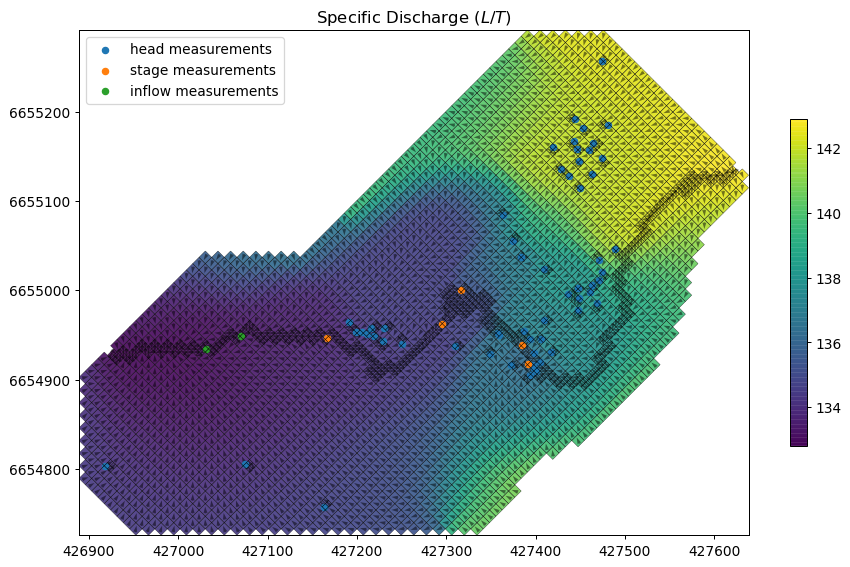

In [55]:
fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=hdata[spd], alpha=0.9, masked_values=[1e30])

quiver = mapview.plot_vector(qx, qy, normalize=True, alpha=0.50)


plt.colorbar(quadmesh, shrink=0.4);

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=25, label=f'{category} measurements')

plt.title("Specific Discharge (" + r"$L/T$" + ")")
plt.legend()
plt.show()

### Hydraulic conductivity:

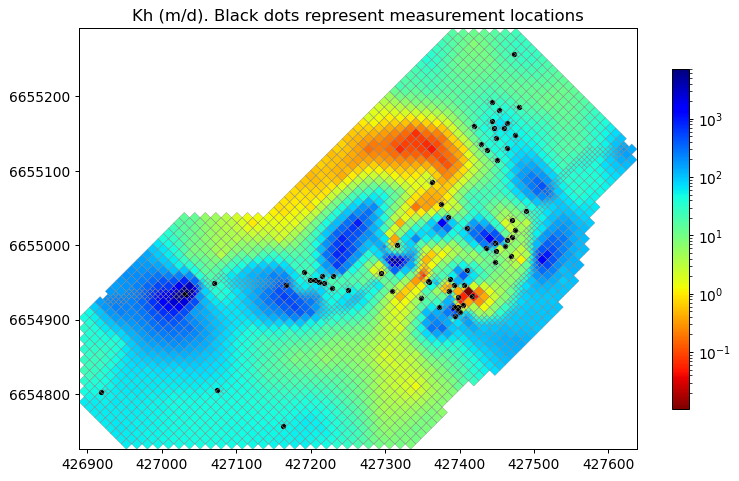

In [57]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25)
gwf_agent.npf.k.plot(masked_values=[0.0], colorbar=True, cmap="jet_r", norm=LogNorm())    

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=10, label=f'{category} measurements', c='k')

plt.title('Kh (m/d). Black dots represent measurement locations')
plt.show()

In [58]:
print('Mean of Kh is: ' + str(gwf_agent.npf.k.data.mean()))
print('Median of Kh is: ' + str(np.median(gwf_agent.npf.k.data)))

Mean of Kh is: 110.05777854192631
Median of Kh is: 37.0315520385


### Storage:

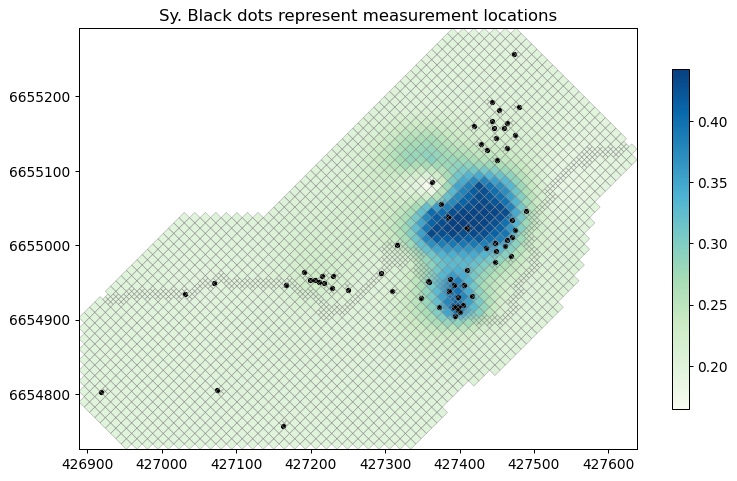

In [59]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Hydraulic Conductivity pilot point locations', fontsize=10)

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25)
gwf_agent.sto.sy.plot(masked_values=[0.0], colorbar=True, cmap="GnBu")

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=10, label=f'{category} measurements', c='k')

plt.title('Sy. Black dots represent measurement locations')

plt.show()

### General head boundary

In [60]:
ghb_spd_df = pd.DataFrame(gwf_agent.ghb.stress_period_data.data[0])
ghb_spd_df['icpl'] = [i[1] for i in gwf_agent.ghb.stress_period_data.data[0].cellid]

In [61]:
ghb_df = pd.DataFrame({'icpl': [i for i in range(gwf_agent.disv.ncpl.array)]})

In [62]:
ghb_arr_df = ghb_df.merge(
    ghb_spd_df[['icpl', 'cond', 'boundname']],
    how='left',
    left_on='icpl',
    right_on='icpl'
).fillna(0)

ghb_arr_df.drop_duplicates(subset='icpl', keep='first', inplace=True, ignore_index=True)

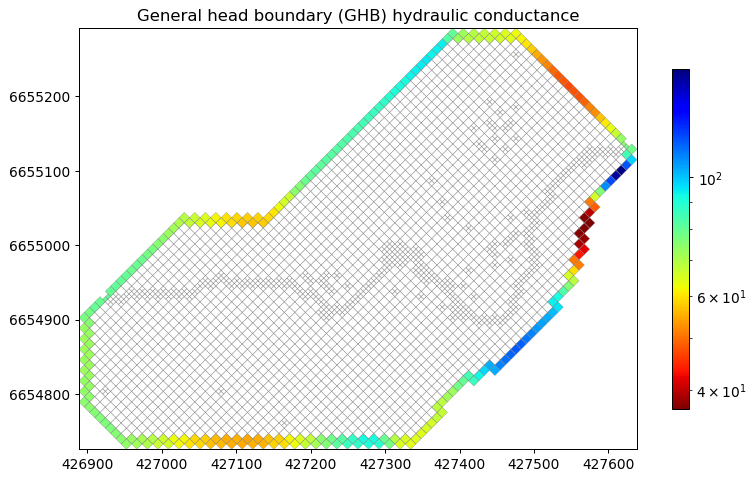

In [63]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0)
quadmesh = mapview.plot_array(ghb_arr_df.cond.values, masked_values=[0.0], cmap='jet_r', norm=LogNorm())
cb = plt.colorbar(quadmesh, shrink=0.5)
linecollection = mapview.plot_grid(lw=0.25)

plt.title('General head boundary (GHB) hydraulic conductance')
plt.show()

In [64]:
with open(os.path.join(agent_ml, 'ghb_new.ts'), 'r') as file:
    ghb_ts = file.readlines()

In [65]:
ghb_ts_start = next(i for i, w in enumerate(ghb_ts) if 'BEGIN TIMESERIES' in w) + 1
ghb_ts_end = next(i for i, w in enumerate(ghb_ts) if 'END TIMESERIES' in w)
ghb_ts_data = [i.split() for i in ghb_ts[ghb_ts_start:ghb_ts_end]]
ghb_ts_cols = ['time', 'red', 'yellow', 'green', 'blue', 'magenta']

In [66]:
ghb_ts_df = pd.DataFrame(ghb_ts_data, columns=ghb_ts_cols)
ghb_ts_df = ghb_ts_df.astype(float)

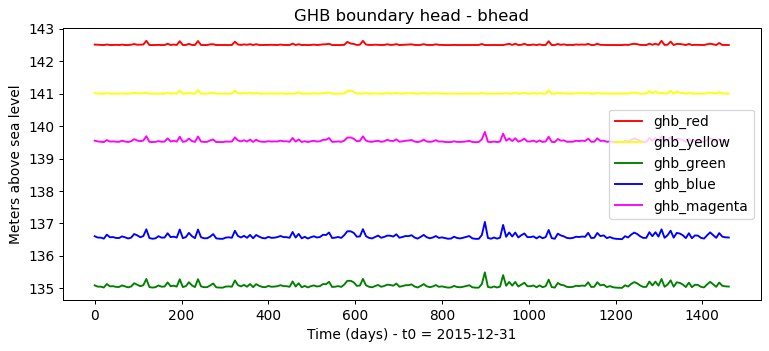

In [67]:
fig = plt.figure(figsize=(10, 4), dpi=90)
ghb_ts_x = ghb_ts_df['time']
for bname in ghb_ts_df.iloc[:, 1:].columns:
    ghb_ts_y = ghb_ts_df[bname]
    plt.plot(ghb_ts_x, ghb_ts_y, color=bname, label=f'ghb_{bname}')
plt.legend()
plt.xlabel('Time (days) - t0 = 2015-12-31')
plt.ylabel('Meters above sea level')
plt.title('GHB boundary head - bhead')
plt.show()

In [68]:
ghb_ts_df.describe()

time         red      yellow       green        blue     magenta
count   209.000000  209.000000  209.000000  209.000000  209.000000  209.000000
mean    730.004785  142.514899  141.011781  135.089049  136.603800  139.550184
std     424.741533    0.025355    0.020258    0.070917    0.077922    0.048822
min       0.000000  142.500000  141.000000  135.010800  136.514500  139.503200
25%     365.000000  142.501400  141.000900  135.043500  136.553000  139.517700
50%     730.000000  142.504100  141.002800  135.065800  136.579000  139.531900
75%    1095.000000  142.517600  141.014300  135.110300  136.629500  139.561100
max    1461.000000  142.631600  141.110500  135.489900  137.045300  139.821500

### Recharge

In [69]:
with open(os.path.join(agent_ml, 'rch_new.ts'), 'r') as file:
    rch_ts = file.readlines()

In [70]:
rch_ts_start = next(i for i, w in enumerate(rch_ts) if 'BEGIN TIMESERIES' in w) + 1
rch_ts_end = next(i for i, w in enumerate(rch_ts) if 'END TIMESERIES' in w)
rch_ts_data = [i.split() for i in rch_ts[rch_ts_start:rch_ts_end]]
rch_ts_cols = ['time', 'rch_lu1']

In [71]:
rch_ts_df = pd.DataFrame(rch_ts_data, columns=rch_ts_cols)
rch_ts_df = rch_ts_df.astype(float)

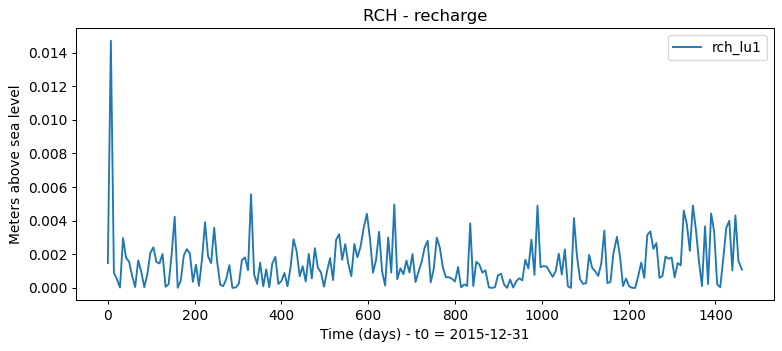

In [72]:
fig = plt.figure(figsize=(10, 4), dpi=90)
rch_ts_x = rch_ts_df['time']
for bname in rch_ts_df.iloc[:, 1:].columns:
    rch_ts_y = rch_ts_df[bname]
    plt.plot(rch_ts_x, rch_ts_y, label=bname)
plt.legend()
plt.xlabel('Time (days) - t0 = 2015-12-31')
plt.ylabel('Meters above sea level')
plt.title('RCH - recharge')
plt.show()

### Streamflow routing

In [73]:
sfr_pkgdata_df = pd.DataFrame(gwf_agent.sfr.packagedata.array)
sfr_pkgdata_df['icpl'] = [i[1] for i in gwf_agent.sfr.packagedata.array.cellid]

In [74]:
sfr_df = pd.DataFrame({'icpl': [i for i in range(gwf_agent.disv.ncpl.array)]})

In [75]:
sfr_arr_df = sfr_df.merge(
    sfr_pkgdata_df[['icpl', 'rno', 'rwid', 'rtp', 'rgrd', 'rbth', 'rhk', 'man']],
    how='left',
    left_on='icpl',
    right_on='icpl'
).fillna(0)

sfr_arr_df['man'] = sfr_arr_df['man'].astype(float)

In [76]:
sfr_df['pred'] = np.zeros_like(sfr_df)

<ipython-input-77-8f25500da4e0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfr_df.iloc[pred1_x.index[0]]['pred'] = 1
<ipython-input-77-8f25500da4e0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfr_df.iloc[pred2_x.index[0]]['pred'] = 2
<ipython-input-77-8f25500da4e0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfr_df.iloc[pred3_x.index[0]]['pred'] = 3


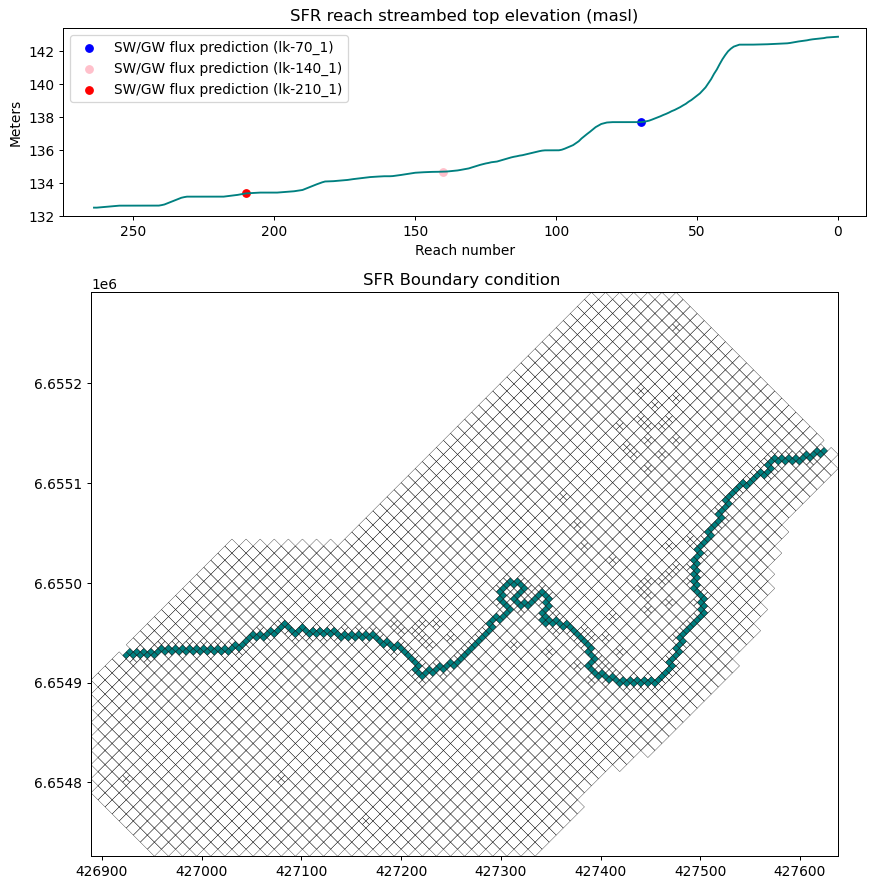

In [77]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=90, gridspec_kw={'height_ratios': [1, 3]})

pred1_x, pred1_y = sfr_arr_df.loc[sfr_arr_df['rno'] == 70]['rno'], sfr_arr_df.loc[sfr_arr_df['rno'] == 70]['rtp']
pred2_x, pred2_y = sfr_arr_df.loc[sfr_arr_df['rno'] == 140]['rno'], sfr_arr_df.loc[sfr_arr_df['rno'] == 140]['rtp']
pred3_x, pred3_y = sfr_arr_df.loc[sfr_arr_df['rno'] == 210]['rno'], sfr_arr_df.loc[sfr_arr_df['rno'] == 210]['rtp']

sfr_df.iloc[pred1_x.index[0]]['pred'] = 1
sfr_df.iloc[pred2_x.index[0]]['pred'] = 2
sfr_df.iloc[pred3_x.index[0]]['pred'] = 3

axs[0].set_title('SFR reach streambed top elevation (masl)')
axs[0].set_ylabel('Meters')
axs[0].set_xlabel('Reach number')

axs[0].plot(sfr_pkgdata_df.rtp, color='teal')
axs[0].set_xlim(len(sfr_pkgdata_df) + 10, -10)

axs[0].scatter(pred1_x, pred1_y, c='b', label='SW/GW flux prediction (lk-70_1)')
axs[0].scatter(pred2_x, pred2_y, color='pink', label='SW/GW flux prediction (lk-140_1)')
axs[0].scatter(pred3_x, pred3_y, c='r', label='SW/GW flux prediction (lk-210_1)')
axs[0].legend()

axs[1].set_aspect('equal')
axs[1].set_title('SFR Boundary condition ')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[1])
linecollection = mapview.plot_grid(lw=0.25, color='k', ax=axs[1])
bc = mapview.plot_bc('SFR', ax=axs[1])
quadmesh = mapview.plot_array(sfr_df.pred, masked_values=[0.0], cmap="bwr", norm=LogNorm())

plt.tight_layout()
plt.show()

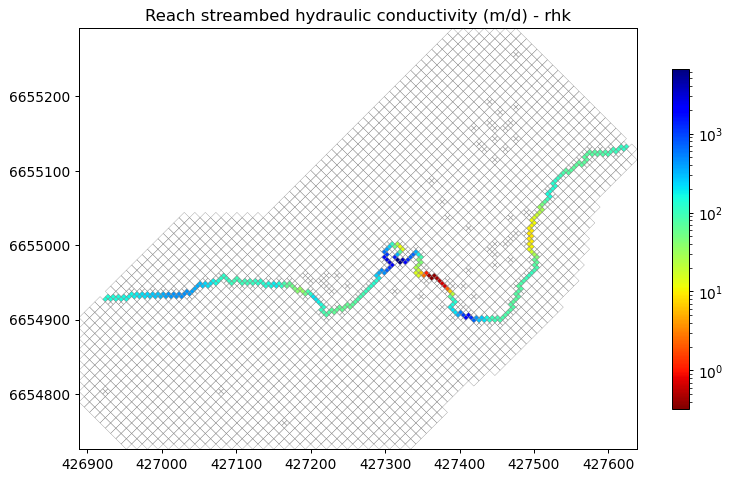

In [78]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0)
quadmesh = mapview.plot_array(sfr_arr_df.rhk.values, masked_values=[0.0], cmap='jet_r', norm=LogNorm())
cb = plt.colorbar(quadmesh, shrink=0.5)
linecollection = mapview.plot_grid(lw=0.25)

plt.title('Reach streambed hydraulic conductivity (m/d) - rhk')
plt.show()

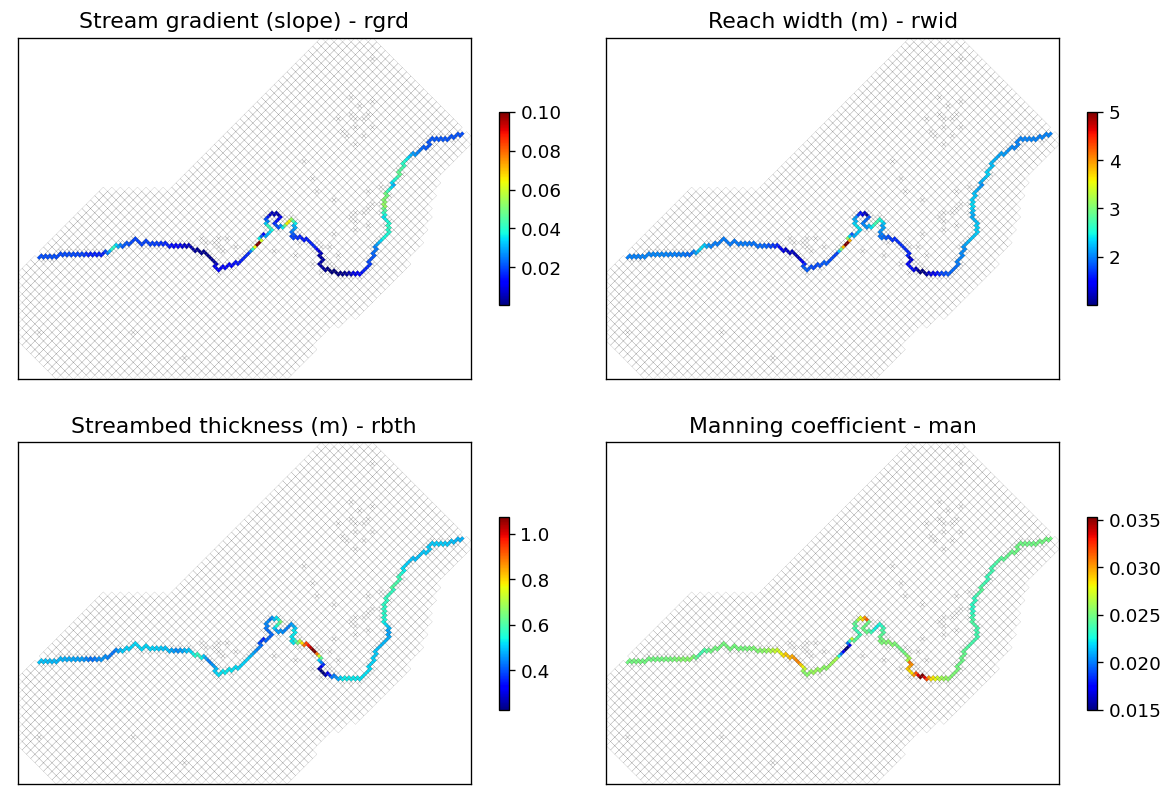

In [79]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7), dpi=120)

axs[0, 0].set_title('Stream gradient (slope) - rgrd')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[0, 0])
quadmesh = mapview.plot_array(sfr_arr_df.rgrd.values, masked_values=[0.0], cmap='jet', ax=axs[0, 0])
cb = plt.colorbar(quadmesh, shrink=0.5, ax=axs[0, 0])

axs[0, 1].set_title('Reach width (m) - rwid')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[0, 1])
quadmesh = mapview.plot_array(sfr_arr_df.rwid.values, masked_values=[0.0], cmap='jet', ax=axs[0, 1])
cb = plt.colorbar(quadmesh, shrink=0.5, ax=axs[0, 1])

axs[1, 0].set_title('Streambed thickness (m) - rbth')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[1, 0])
quadmesh = mapview.plot_array(sfr_arr_df.rbth.values, masked_values=[0.0], cmap='jet', ax=axs[1, 0])
cb = plt.colorbar(quadmesh, shrink=0.5, ax=axs[1, 0])

axs[1, 1].set_title('Manning coefficient - man')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[1, 1])
quadmesh = mapview.plot_array(sfr_arr_df.man.values, masked_values=[0.0], cmap='jet', ax=axs[1, 1])
cb = plt.colorbar(quadmesh, shrink=0.5, ax=axs[1, 1])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set_aspect('equal')
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.label_outer()
    linecollection = mapview.plot_grid(lw=0.05, color='k', ax=ax)
    
plt.tight_layout()

## Begin linear uncertainty analysis

In [80]:
p = subprocess.run(['pwtadj2', 'calib-parrep.pst', 'calib-parrep-pwtadj2.pst', 'ng'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 PWTADJ2 version 17.3. Watermark Numerical Computing.

 - reading PEST control file calib-parrep.pst for first time...

 - reading PEST run record file calib-parrep.rec...
 - file calib-parrep.rec read ok.

 - re-reading file calib-parrep.pst and writing file calib-parrep-pwtadj2.pst...
 - file calib-parrep.pst read ok.
 - file calib-parrep-pwtadj2.pst written ok.



Set PEST mode to *estimation* and remove prior information:

In [81]:
p = subprocess.run(['subreg1', 'calib-parrep-pwtadj2.pst', 'linunc.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 SUBREG1 version 17.3. Watermark Numerical Computing.

 - file calib-parrep-pwtadj2.pst read ok.
 - file linunc.pst written ok.



Calculate a jacobian matrix that correspond to `linunc.pst`. **Takes 4-5 minutes**:

In [83]:
p = subprocess.run(['i64jco2jco', 'calib-parrep.pst', 'linunc.pst',], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)

 JCO2JCO Version 17.3. Watermark Numerical Computing.
 - file calib-parrep.pst read ok.
 - file calib-parrep.jco read ok.
 - file linunc.pst read ok.
 - file linunc.jco written ok.



In [17]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

Write uncertainty file. **Manual checkup required**.

In [18]:
with open(os.path.join(pest_ws, 'linunc.pst'), 'r') as file:
    pstfile = file.readlines() #pestfile partial parameters

pardata_start = pstfile.index('* parameter data\n') + 1
pardata_stop = pstfile.index('* observation groups\n')

pardata_df = pd.DataFrame(pstfile[pardata_start:pardata_stop]) # read df

In [19]:
pardata_df.iloc[:,0] = pardata_df.iloc[:,0].str.replace(r'\ (?= *?\ )', '') # clean up data structure
pardata_cols = ['PARNME', 'PARTRANS', 'PARCHGLIM', 'PARVAL1', 'PARLBND', 'PARUBND', 'PARGP', 'SCALE', 'OFFSET']
pardata_df[pardata_cols] = pardata_df[0].str.split(' ', 9, expand=True) # add columns
pardata_df = pardata_df[pardata_cols] # remove redundant column
display(pardata_df) # view df

PARNME PARTRANS PARCHGLIM    PARVAL1 PARLBND PARUBND   PARGP SCALE  \
0     crfac_blu      log    factor  0.5000956    0.01     0.9  lrgblu   1.0   
1     crfac_gre      log    factor  0.5000386    0.01     0.9  lrggre   1.0   
2     crfac_lu1      log    factor  0.5032869    0.01     0.9   lrrch   1.0   
3     crfac_mag      log    factor  0.5001545    0.01     0.9  lrgmag   1.0   
4     crfac_red      log    factor  0.5000303    0.01     0.9  lrgred   1.0   
...         ...      ...       ...        ...     ...     ...     ...   ...   
2060    sypp219      log    factor  0.1984715    0.01    0.44    sypp   1.0   
2061    sypp220      log    factor  0.1952849    0.01    0.44    sypp   1.0   
2062    sypp221      log    factor  0.1946681    0.01    0.44    sypp   1.0   
2063    sypp222      log    factor  0.1963386    0.01    0.44    sypp   1.0   
2064    sypp223      log    factor  0.1984226    0.01    0.44    sypp   1.0   

     OFFSET  
0     0.0\n  
1     0.0\n  
2     0.0\n  
3     0.0\n  
4     0.0\n  
...     ...  
2060  0.0\n  
2061  0.0\n  
2062  0.0\n  
2063  0.0\n  
2064  0.0\n  

[2065 rows x 9 columns]

In [20]:
print(pardata_df.PARGP.unique())

['lrgblu' 'lrggre' 'lrrch' 'lrgmag' 'lrgred' 'lrgyel' 'ghbblu' 'ghbgre'
 'ghbmag' 'ghbred' 'ghbyel' 'khpp' 'sfreva' 'sfrinf' 'sfrman' 'sfrbth'
 'sfrgrd' 'sfrrhk' 'sfrwid' 'sfrrai' 'sfrtpo' 'sfrtpw' 'sypp']


In [21]:
def estimate_variance_multiplier(pargp):
    
    # Get partrans (for printing purposes)
    partrans = pardata_df.loc[pardata_df['PARGP'] == pargp].reset_index()['PARTRANS'][0]
    
    # Determine parameter span
    parvals = pardata_df.loc[pardata_df['PARGP'] == pargp]['PARVAL1'].astype(float)
    
    if partrans == 'log':
        variance_multiplier = np.var(np.log10(parvals))
    else:
        variance_multiplier = np.var(parvals)

    print(f'PARTRANS is {partrans}')
    
    return variance_multiplier

In [22]:
estimate_variance_multiplier('sfrrai')

PARTRANS is log


nan

In [23]:
def estimate_stdev_multiplier(lbnd, ubnd, partrans=None):
    
    if partrans == 'log':
        stdev_multiplier = np.std(np.log10([lbnd, ubnd]))
    else:
        stdev_multiplier = np.sdt([lbnd, ubnd])

    print(f'PARTRANS is {partrans}')
    
    return stdev_multiplier

In [24]:
estimate_stdev_multiplier(
    lbnd=pardata_df.loc[pardata_df['PARGP'] == 'sfrrai']['PARLBND'].astype(float).min(),
    ubnd=pardata_df.loc[pardata_df['PARGP'] == 'sfrrai']['PARUBND'].astype(float).max(),
    partrans='log'
)

PARTRANS is log


nan

In [25]:
sfrevapo_par_stdev = [i+" 1.75\n" for i in list(pardata_df.loc[pardata_df["PARGP"] == "sfreva"]["PARNME"])]

In [26]:
sfrr1inf_par_stdev = [i+" 1.08\n" for i in list(pardata_df.loc[pardata_df["PARGP"] == "sfrinf"]["PARNME"])]

In [27]:
write_script(os.path.join(pest_ws, 'param.unc'), [
f'''
### HYDRAULIC CONDUCTIVITY ###

# Kh
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_cond.mat"
first_parameter khpp001
last_parameter khpp680
variance_multiplier 0.25
END COVARIANCE_MATRIX


### STORAGE ###

# Sy
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sto.mat"
first_parameter sypp001
last_parameter sypp223
variance_multiplier 0.01 # Should be fine
END COVARIANCE_MATRIX


### GENERAL HEAD BOUNDARIES ###

# GHB Red
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghbred.mat"
first_parameter ghbcredpp001
last_parameter ghbcredpp025
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Yellow
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghbyel.mat"
first_parameter ghbcyelpp026
last_parameter ghbcyelpp062
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Green
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghbgre.mat"
first_parameter ghbcgrepp063
last_parameter ghbcgrepp094
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Blue
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghbblu.mat"
first_parameter ghbcblupp095
last_parameter ghbcblupp116
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Magenta
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghbmag.mat"
first_parameter ghbcmagpp117
last_parameter ghbcmagpp134
variance_multiplier 0.25
END COVARIANCE_MATRIX


### STREAMFLOW ROUTING ###

# SFR man
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrppman001
last_parameter sfrppman069
variance_multiplier 0.25
END COVARIANCE_MATRIX

# SFR bth
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprbth001
last_parameter sfrpprbth069
variance_multiplier 0.01
END COVARIANCE_MATRIX

# SFR grd
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprgrd001
last_parameter sfrpprgrd069
variance_multiplier 0.2
END COVARIANCE_MATRIX

# SFR wid
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprwid001
last_parameter sfrpprwid069
variance_multiplier 0.2
END COVARIANCE_MATRIX

# SFR rhk
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprhk001
last_parameter sfrpprhk069
variance_multiplier 0.25
END COVARIANCE_MATRIX


### NON COVARIANCE MATRIX PARAMETERS ###

# SFR rtp
START STANDARD_DEVIATION
sfrrtpo 1.08
sfrrtpw 1.0
END STANDARD_DEVIATION

# SFR reach evaporation
START STANDARD_DEVIATION
sfrevapo000 1.75
sfrevapo001 1.75
sfrevapo002 1.75
sfrevapo003 1.75
sfrevapo004 1.75
sfrevapo005 1.75
sfrevapo006 1.75
sfrevapo007 1.75
sfrevapo008 1.75
sfrevapo009 1.75
sfrevapo010 1.75
sfrevapo011 1.75
sfrevapo012 1.75
sfrevapo013 1.75
sfrevapo014 1.75
sfrevapo015 1.75
sfrevapo016 1.75
sfrevapo017 1.75
sfrevapo018 1.75
sfrevapo019 1.75
sfrevapo020 1.75
sfrevapo021 1.75
sfrevapo022 1.75
sfrevapo023 1.75
sfrevapo024 1.75
sfrevapo025 1.75
sfrevapo026 1.75
sfrevapo027 1.75
sfrevapo028 1.75
sfrevapo029 1.75
sfrevapo030 1.75
sfrevapo031 1.75
sfrevapo032 1.75
sfrevapo033 1.75
sfrevapo034 1.75
sfrevapo035 1.75
sfrevapo036 1.75
sfrevapo037 1.75
sfrevapo038 1.75
sfrevapo039 1.75
sfrevapo040 1.75
sfrevapo041 1.75
sfrevapo042 1.75
sfrevapo043 1.75
sfrevapo044 1.75
sfrevapo045 1.75
sfrevapo046 1.75
sfrevapo047 1.75
sfrevapo048 1.75
sfrevapo049 1.75
sfrevapo050 1.75
sfrevapo051 1.75
sfrevapo052 1.75
sfrevapo053 1.75
sfrevapo054 1.75
sfrevapo055 1.75
sfrevapo056 1.75
sfrevapo057 1.75
sfrevapo058 1.75
sfrevapo059 1.75
sfrevapo060 1.75
sfrevapo061 1.75
sfrevapo062 1.75
sfrevapo063 1.75
sfrevapo064 1.75
sfrevapo065 1.75
sfrevapo066 1.75
sfrevapo067 1.75
sfrevapo068 1.75
sfrevapo069 1.75
sfrevapo070 1.75
sfrevapo071 1.75
sfrevapo072 1.75
sfrevapo073 1.75
sfrevapo074 1.75
sfrevapo075 1.75
sfrevapo076 1.75
sfrevapo077 1.75
sfrevapo078 1.75
sfrevapo079 1.75
sfrevapo080 1.75
sfrevapo081 1.75
sfrevapo082 1.75
sfrevapo083 1.75
sfrevapo084 1.75
sfrevapo085 1.75
sfrevapo086 1.75
sfrevapo087 1.75
sfrevapo088 1.75
sfrevapo089 1.75
sfrevapo090 1.75
sfrevapo091 1.75
sfrevapo092 1.75
sfrevapo093 1.75
sfrevapo094 1.75
sfrevapo095 1.75
sfrevapo096 1.75
sfrevapo097 1.75
sfrevapo098 1.75
sfrevapo099 1.75
sfrevapo100 1.75
sfrevapo101 1.75
sfrevapo102 1.75
sfrevapo103 1.75
sfrevapo104 1.75
sfrevapo105 1.75
sfrevapo106 1.75
sfrevapo107 1.75
sfrevapo108 1.75
sfrevapo109 1.75
sfrevapo110 1.75
sfrevapo111 1.75
sfrevapo112 1.75
sfrevapo113 1.75
sfrevapo114 1.75
sfrevapo115 1.75
sfrevapo116 1.75
sfrevapo117 1.75
sfrevapo118 1.75
sfrevapo119 1.75
sfrevapo120 1.75
sfrevapo121 1.75
sfrevapo122 1.75
sfrevapo123 1.75
sfrevapo124 1.75
sfrevapo125 1.75
sfrevapo126 1.75
sfrevapo127 1.75
sfrevapo128 1.75
sfrevapo129 1.75
sfrevapo130 1.75
sfrevapo131 1.75
sfrevapo132 1.75
sfrevapo133 1.75
sfrevapo134 1.75
sfrevapo135 1.75
sfrevapo136 1.75
sfrevapo137 1.75
sfrevapo138 1.75
sfrevapo139 1.75
sfrevapo140 1.75
sfrevapo141 1.75
sfrevapo142 1.75
sfrevapo143 1.75
sfrevapo144 1.75
sfrevapo145 1.75
sfrevapo146 1.75
sfrevapo147 1.75
sfrevapo148 1.75
sfrevapo149 1.75
sfrevapo150 1.75
sfrevapo151 1.75
sfrevapo152 1.75
sfrevapo153 1.75
sfrevapo154 1.75
sfrevapo155 1.75
sfrevapo156 1.75
sfrevapo157 1.75
sfrevapo158 1.75
sfrevapo159 1.75
sfrevapo160 1.75
sfrevapo161 1.75
sfrevapo162 1.75
sfrevapo163 1.75
sfrevapo164 1.75
sfrevapo165 1.75
sfrevapo166 1.75
sfrevapo167 1.75
sfrevapo168 1.75
sfrevapo169 1.75
sfrevapo170 1.75
sfrevapo171 1.75
sfrevapo172 1.75
sfrevapo173 1.75
sfrevapo174 1.75
sfrevapo175 1.75
sfrevapo176 1.75
sfrevapo177 1.75
sfrevapo178 1.75
sfrevapo179 1.75
sfrevapo180 1.75
sfrevapo181 1.75
sfrevapo182 1.75
sfrevapo183 1.75
sfrevapo184 1.75
sfrevapo185 1.75
sfrevapo186 1.75
sfrevapo187 1.75
sfrevapo188 1.75
sfrevapo189 1.75
sfrevapo190 1.75
sfrevapo191 1.75
sfrevapo192 1.75
sfrevapo193 1.75
sfrevapo194 1.75
sfrevapo195 1.75
sfrevapo196 1.75
sfrevapo197 1.75
sfrevapo198 1.75
sfrevapo199 1.75
sfrevapo200 1.75
sfrevapo201 1.75
sfrevapo202 1.75
sfrevapo203 1.75
sfrevapo204 1.75
sfrevapo205 1.75
sfrevapo206 1.75
sfrevapo207 1.75
sfrevapo208 1.75
END STANDARD_DEVIATION

# SFR reach 1 inflow
START STANDARD_DEVIATION
sfrinflow000 1.08
sfrinflow001 1.08
sfrinflow002 1.08
sfrinflow003 1.08
sfrinflow004 1.08
sfrinflow005 1.08
sfrinflow006 1.08
sfrinflow007 1.08
sfrinflow008 1.08
sfrinflow009 1.08
sfrinflow010 1.08
sfrinflow011 1.08
sfrinflow012 1.08
sfrinflow013 1.08
sfrinflow014 1.08
sfrinflow015 1.08
sfrinflow016 1.08
sfrinflow017 1.08
sfrinflow018 1.08
sfrinflow019 1.08
sfrinflow020 1.08
sfrinflow021 1.08
sfrinflow022 1.08
sfrinflow023 1.08
sfrinflow024 1.08
sfrinflow025 1.08
sfrinflow026 1.08
sfrinflow027 1.08
sfrinflow028 1.08
sfrinflow029 1.08
sfrinflow030 1.08
sfrinflow031 1.08
sfrinflow032 1.08
sfrinflow033 1.08
sfrinflow034 1.08
sfrinflow035 1.08
sfrinflow036 1.08
sfrinflow037 1.08
sfrinflow038 1.08
sfrinflow039 1.08
sfrinflow040 1.08
sfrinflow041 1.08
sfrinflow042 1.08
sfrinflow043 1.08
sfrinflow044 1.08
sfrinflow045 1.08
sfrinflow046 1.08
sfrinflow047 1.08
sfrinflow048 1.08
sfrinflow049 1.08
sfrinflow050 1.08
sfrinflow051 1.08
sfrinflow052 1.08
sfrinflow053 1.08
sfrinflow054 1.08
sfrinflow055 1.08
sfrinflow056 1.08
sfrinflow057 1.08
sfrinflow058 1.08
sfrinflow059 1.08
sfrinflow060 1.08
sfrinflow061 1.08
sfrinflow062 1.08
sfrinflow063 1.08
sfrinflow064 1.08
sfrinflow065 1.08
sfrinflow066 1.08
sfrinflow067 1.08
sfrinflow068 1.08
sfrinflow069 1.08
sfrinflow070 1.08
sfrinflow071 1.08
sfrinflow072 1.08
sfrinflow073 1.08
sfrinflow074 1.08
sfrinflow075 1.08
sfrinflow076 1.08
sfrinflow077 1.08
sfrinflow078 1.08
sfrinflow079 1.08
sfrinflow080 1.08
sfrinflow081 1.08
sfrinflow082 1.08
sfrinflow083 1.08
sfrinflow084 1.08
sfrinflow085 1.08
sfrinflow086 1.08
sfrinflow087 1.08
sfrinflow088 1.08
sfrinflow089 1.08
sfrinflow090 1.08
sfrinflow091 1.08
sfrinflow092 1.08
sfrinflow093 1.08
sfrinflow094 1.08
sfrinflow095 1.08
sfrinflow096 1.08
sfrinflow097 1.08
sfrinflow098 1.08
sfrinflow099 1.08
sfrinflow100 1.08
sfrinflow101 1.08
sfrinflow102 1.08
sfrinflow103 1.08
sfrinflow104 1.08
sfrinflow105 1.08
sfrinflow106 1.08
sfrinflow107 1.08
sfrinflow108 1.08
sfrinflow109 1.08
sfrinflow110 1.08
sfrinflow111 1.08
sfrinflow112 1.08
sfrinflow113 1.08
sfrinflow114 1.08
sfrinflow115 1.08
sfrinflow116 1.08
sfrinflow117 1.08
sfrinflow118 1.08
sfrinflow119 1.08
sfrinflow120 1.08
sfrinflow121 1.08
sfrinflow122 1.08
sfrinflow123 1.08
sfrinflow124 1.08
sfrinflow125 1.08
sfrinflow126 1.08
sfrinflow127 1.08
sfrinflow128 1.08
sfrinflow129 1.08
sfrinflow130 1.08
sfrinflow131 1.08
sfrinflow132 1.08
sfrinflow133 1.08
sfrinflow134 1.08
sfrinflow135 1.08
sfrinflow136 1.08
sfrinflow137 1.08
sfrinflow138 1.08
sfrinflow139 1.08
sfrinflow140 1.08
sfrinflow141 1.08
sfrinflow142 1.08
sfrinflow143 1.08
sfrinflow144 1.08
sfrinflow145 1.08
sfrinflow146 1.08
sfrinflow147 1.08
sfrinflow148 1.08
sfrinflow149 1.08
sfrinflow150 1.08
sfrinflow151 1.08
sfrinflow152 1.08
sfrinflow153 1.08
sfrinflow154 1.08
sfrinflow155 1.08
sfrinflow156 1.08
sfrinflow157 1.08
sfrinflow158 1.08
sfrinflow159 1.08
sfrinflow160 1.08
sfrinflow161 1.08
sfrinflow162 1.08
sfrinflow163 1.08
sfrinflow164 1.08
sfrinflow165 1.08
sfrinflow166 1.08
sfrinflow167 1.08
sfrinflow168 1.08
sfrinflow169 1.08
sfrinflow170 1.08
sfrinflow171 1.08
sfrinflow172 1.08
sfrinflow173 1.08
sfrinflow174 1.08
sfrinflow175 1.08
sfrinflow176 1.08
sfrinflow177 1.08
sfrinflow178 1.08
sfrinflow179 1.08
sfrinflow180 1.08
sfrinflow181 1.08
sfrinflow182 1.08
sfrinflow183 1.08
sfrinflow184 1.08
sfrinflow185 1.08
sfrinflow186 1.08
sfrinflow187 1.08
sfrinflow188 1.08
sfrinflow189 1.08
sfrinflow190 1.08
sfrinflow191 1.08
sfrinflow192 1.08
sfrinflow193 1.08
sfrinflow194 1.08
sfrinflow195 1.08
sfrinflow196 1.08
sfrinflow197 1.08
sfrinflow198 1.08
sfrinflow199 1.08
sfrinflow200 1.08
sfrinflow201 1.08
sfrinflow202 1.08
sfrinflow203 1.08
sfrinflow204 1.08
sfrinflow205 1.08
sfrinflow206 1.08
sfrinflow207 1.08
sfrinflow208 1.08
END STANDARD_DEVIATION

# SFR reach rain inflow
START STANDARD_DEVIATION
sfrrainf000 3.34
sfrrainf001 3.34
sfrrainf002 3.34
sfrrainf003 3.34
sfrrainf004 3.34
sfrrainf005 3.34
sfrrainf006 3.34
sfrrainf007 3.34
sfrrainf008 3.34
sfrrainf009 3.34
sfrrainf010 3.34
sfrrainf011 3.34
sfrrainf012 3.34
sfrrainf013 3.34
sfrrainf014 3.34
sfrrainf015 3.34
sfrrainf016 3.34
sfrrainf017 3.34
sfrrainf018 3.34
sfrrainf019 3.34
sfrrainf020 3.34
sfrrainf021 3.34
sfrrainf022 3.34
sfrrainf023 3.34
sfrrainf024 3.34
sfrrainf025 3.34
sfrrainf026 3.34
sfrrainf027 3.34
sfrrainf028 3.34
sfrrainf029 3.34
sfrrainf030 3.34
sfrrainf031 3.34
sfrrainf032 3.34
sfrrainf033 3.34
sfrrainf034 3.34
sfrrainf035 3.34
sfrrainf036 3.34
sfrrainf037 3.34
sfrrainf038 3.34
sfrrainf039 3.34
sfrrainf040 3.34
sfrrainf041 3.34
sfrrainf042 3.34
sfrrainf043 3.34
sfrrainf044 3.34
sfrrainf045 3.34
sfrrainf046 3.34
sfrrainf047 3.34
sfrrainf048 3.34
sfrrainf049 3.34
sfrrainf050 3.34
sfrrainf051 3.34
sfrrainf052 3.34
sfrrainf053 3.34
sfrrainf054 3.34
sfrrainf055 3.34
sfrrainf056 3.34
sfrrainf057 3.34
sfrrainf058 3.34
sfrrainf059 3.34
sfrrainf060 3.34
sfrrainf061 3.34
sfrrainf062 3.34
sfrrainf063 3.34
sfrrainf064 3.34
sfrrainf065 3.34
sfrrainf066 3.34
sfrrainf067 3.34
sfrrainf068 3.34
sfrrainf069 3.34
sfrrainf070 3.34
sfrrainf071 3.34
sfrrainf072 3.34
sfrrainf073 3.34
sfrrainf074 3.34
sfrrainf075 3.34
sfrrainf076 3.34
sfrrainf077 3.34
sfrrainf078 3.34
sfrrainf079 3.34
sfrrainf080 3.34
sfrrainf081 3.34
sfrrainf082 3.34
sfrrainf083 3.34
sfrrainf084 3.34
sfrrainf085 3.34
sfrrainf086 3.34
sfrrainf087 3.34
sfrrainf088 3.34
sfrrainf089 3.34
sfrrainf090 3.34
sfrrainf091 3.34
sfrrainf092 3.34
sfrrainf093 3.34
sfrrainf094 3.34
sfrrainf095 3.34
sfrrainf096 3.34
sfrrainf097 3.34
sfrrainf098 3.34
sfrrainf099 3.34
sfrrainf100 3.34
sfrrainf101 3.34
sfrrainf102 3.34
sfrrainf103 3.34
sfrrainf104 3.34
sfrrainf105 3.34
sfrrainf106 3.34
sfrrainf107 3.34
sfrrainf108 3.34
sfrrainf109 3.34
sfrrainf110 3.34
sfrrainf111 3.34
sfrrainf112 3.34
sfrrainf113 3.34
sfrrainf114 3.34
sfrrainf115 3.34
sfrrainf116 3.34
sfrrainf117 3.34
sfrrainf118 3.34
sfrrainf119 3.34
sfrrainf120 3.34
sfrrainf121 3.34
sfrrainf122 3.34
sfrrainf123 3.34
sfrrainf124 3.34
sfrrainf125 3.34
sfrrainf126 3.34
sfrrainf127 3.34
sfrrainf128 3.34
sfrrainf129 3.34
sfrrainf130 3.34
sfrrainf131 3.34
sfrrainf132 3.34
sfrrainf133 3.34
sfrrainf134 3.34
sfrrainf135 3.34
sfrrainf136 3.34
sfrrainf137 3.34
sfrrainf138 3.34
sfrrainf139 3.34
sfrrainf140 3.34
sfrrainf141 3.34
sfrrainf142 3.34
sfrrainf143 3.34
sfrrainf144 3.34
sfrrainf145 3.34
sfrrainf146 3.34
sfrrainf147 3.34
sfrrainf148 3.34
sfrrainf149 3.34
sfrrainf150 3.34
sfrrainf151 3.34
sfrrainf152 3.34
sfrrainf153 3.34
sfrrainf154 3.34
sfrrainf155 3.34
sfrrainf156 3.34
sfrrainf157 3.34
sfrrainf158 3.34
sfrrainf159 3.34
sfrrainf160 3.34
sfrrainf161 3.34
sfrrainf162 3.34
sfrrainf163 3.34
sfrrainf164 3.34
sfrrainf165 3.34
sfrrainf166 3.34
sfrrainf167 3.34
sfrrainf168 3.34
sfrrainf169 3.34
sfrrainf170 3.34
sfrrainf171 3.34
sfrrainf172 3.34
sfrrainf173 3.34
sfrrainf174 3.34
sfrrainf175 3.34
sfrrainf176 3.34
sfrrainf177 3.34
sfrrainf178 3.34
sfrrainf179 3.34
sfrrainf180 3.34
sfrrainf181 3.34
sfrrainf182 3.34
sfrrainf183 3.34
sfrrainf184 3.34
sfrrainf185 3.34
sfrrainf186 3.34
sfrrainf187 3.34
sfrrainf188 3.34
sfrrainf189 3.34
sfrrainf190 3.34
sfrrainf191 3.34
sfrrainf192 3.34
sfrrainf193 3.34
sfrrainf194 3.34
sfrrainf195 3.34
sfrrainf196 3.34
sfrrainf197 3.34
sfrrainf198 3.34
sfrrainf199 3.34
sfrrainf200 3.34
sfrrainf201 3.34
sfrrainf202 3.34
sfrrainf203 3.34
sfrrainf204 3.34
sfrrainf205 3.34
sfrrainf206 3.34
sfrrainf207 3.34
sfrrainf208 3.34
END STANDARD_DEVIATION

# Lumprem crop factor
START STANDARD_DEVIATION
crfac_lu1 1.0
crfac_red 1.0
crfac_yel 1.0
crfac_gre 1.0
crfac_blu 1.0
crfac_mag 1.0
END STANDARD_DEVIATION

# Lumprem gamma
START STANDARD_DEVIATION
gamma_lu1 1.5
gamma_red 1.5
gamma_yel 1.5
gamma_gre 1.5
gamma_blu 1.5
gamma_mag 1.5
END STANDARD_DEVIATION

# Lumprem ks
START STANDARD_DEVIATION
ks_lu1 1.0
ks_red 1.0
ks_yel 1.0
ks_gre 1.0
ks_blu 1.0
ks_mag 1.0
END STANDARD_DEVIATION

# Lumprem l
START STANDARD_DEVIATION
l_lu1 1.0
l_red 1.0
l_yel 1.0
l_gre 1.0
l_blu 1.0
l_mag 1.0
END STANDARD_DEVIATION

# Lumprem m
START STANDARD_DEVIATION
m_lu1 1.15
m_red 1.15
m_yel 1.15
m_gre 1.15
m_blu 1.15
m_mag 1.15
END STANDARD_DEVIATION

# Lumprem maxvol
START STANDARD_DEVIATION
maxvol_lu1 1.0
maxvol_red 1.0
maxvol_yel 1.0
maxvol_gre 1.0
maxvol_blu 1.0
maxvol_mag 1.0
END STANDARD_DEVIATION

# Lumprem mdelay - får lbnd vara < 1?
START STANDARD_DEVIATION
mdelay_lu1 1.3
mdelay_red 1.3
mdelay_yel 1.3
mdelay_gre 1.3
mdelay_blu 1.3
mdelay_mag 1.3
END STANDARD_DEVIATION

# Lumprem mfmax
START STANDARD_DEVIATION
mfmax_lu1 0.6
mfmax_red 0.6
mfmax_yel 0.6
mfmax_gre 0.6
mfmax_blu 0.6
mfmax_mag 0.6
END STANDARD_DEVIATION

# Lumprem rdelay
START STANDARD_DEVIATION
rdelay_lu1 0.6
rdelay_red 0.6
rdelay_yel 0.6
rdelay_gre 0.6
rdelay_blu 0.6
rdelay_mag 0.6
END STANDARD_DEVIATION
'''
])

In [28]:
# Run in pest_ws

In [ ]:
p = subprocess.run([
    'i64genlinpred_abbrev',
    'linunc.pst', # pst control file
    'u', # use uncertainty file
    'param.unc', # name of unc file
    'y', # observation weights are the inverse of measurement noise (?)
    'genlinpred_abbrev.out', # outfile
    'y', # comprehensive analysis of specific prediction
    'lk-70_1', # ska individuella observationer anges är det ohållbart tidsmässigt
    'linunc.jco'
], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)

GENLINPRED Doesn't seem to work using subprocess. **Run manually**.

### SUPCALC

Import results (sw/gw exchange reach 70, spd 1):

In [29]:
def print_supcalc_results(ws, filename):
    '''
    This function takes a GENLINPRED_ABBREV output file
    and prints SUPCALC results
    '''
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
    
    begin_supcalc_idx = next(i for i, w in enumerate(outfile) if f'Outcomes of running program SUPCALC' in w)
    end_supcalc_idx = begin_supcalc_idx + 4
    
    supcalc_rows = outfile[begin_supcalc_idx:end_supcalc_idx]
    
    for row in supcalc_rows:
        print(row)

In [149]:
print_supcalc_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

 Outcomes of running program SUPCALC ----->

 

    Number of dimensions of calibration solution space = 262

    Number of dimensions of calibration null space     = 1790



In [150]:
def get_supcalc_results(ws, filename):
    '''
    This function takes a GENLINPRED_ABBREV output file
    and returns a pandas dataframe of SUPCALC results
    '''
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
        
    # Setup indices
    begin_identpar_idx = next(i for i, w in enumerate(outfile) if 'Outcomes of parameter identifiability' in w)
    end_identpar_idx = next(i for i, w in enumerate(outfile) if 'Note: run IDENTPAR' in w) - 1
    
    # Get columns and data
    supcalc_cols = [column.lower() for column in outfile[begin_identpar_idx + 2].split()]
    supcalc_data = [i.split() for i in outfile[begin_identpar_idx + 4:end_identpar_idx]]
    
    # Instantiate dataframe
    df = pd.DataFrame(supcalc_data, columns=supcalc_cols)
    
    # Convert data to float
    for col in ['identifiability', 'rel_uncert_var_redn']:
        df[col] = df[col].astype(float)
    
    return df

In [151]:
supcalc_res = get_supcalc_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [152]:
# Create empty parameter group columns
supcalc_res['pargp'] = ''

In [153]:
# Create parameter group dictionary
# Edit as needed
pargps = {
    'red': 'ghbred', 'yel': 'ghbyellow', 'gre': 'ghbgreen', 'blu': 'ghbblue',
    'mag':'ghbmagenta', 'lu1': 'recharge', 'khpp': 'khpp', 'sypp': 'sypp',
    'sfrrainf': 'sfrrai', 'sfrrt': 'sfrrtp', 'sfreva': 'sfrevapo', 'sfrpprwid': 'sfrpprwid',
    'sfrpprgrd': 'sfrpprgrd', 'sfrpprhk': 'sfrpprhk', 'sfrpprbth': 'sfrpprbth',
    'sfrppman': 'sfrppman',  'sfrinflow': 'sfrinflow'
}

In [154]:
# Map dictionary to pargp column
for k,v in pargps.items():
    supcalc_res.loc[supcalc_res['parameter'].str.contains(k), 'pargp'] = v

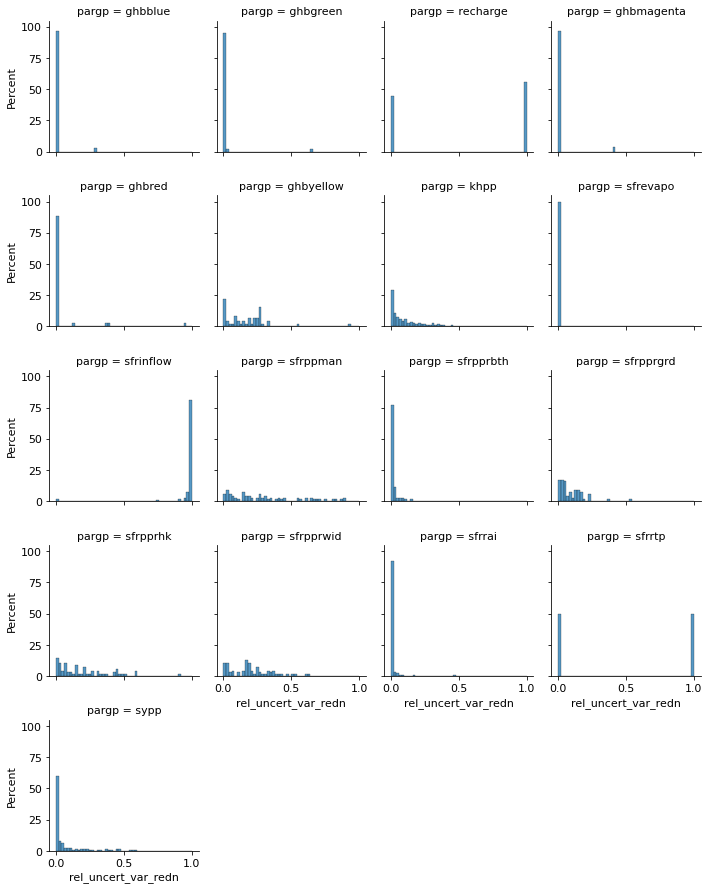

In [155]:
# Create subsets of supcalc df to make more visually clear plots
sns.displot(
    supcalc_res,
    x='rel_uncert_var_redn',
    col='pargp',
    binwidth=0.02,
    height=2.5,
    facet_kws=dict(margin_titles=True),
    col_wrap=4,
    stat='percent',
    common_norm=False
)
plt.savefig('ruvrdn.png')

In [156]:
#supcalc_res.melt(var='pargp')
supcalc_res.pivot(columns='pargp', values='rel_uncert_var_redn').describe()

pargp    ghbblue   ghbgreen  ghbmagenta     ghbred  ghbyellow        khpp  \
count  31.000000  41.000000   27.000000  34.000000  46.000000  680.000000   
mean    0.010532   0.017983    0.017464   0.059569   0.172431    0.136871   
std     0.050852   0.101180    0.079810   0.183363   0.167010    0.175940   
min     0.000000   0.000000    0.000000   0.000000   0.000000    0.000125   
25%     0.000540   0.000477    0.000229   0.003678   0.037610    0.013899   
50%     0.001011   0.001268    0.000911   0.004237   0.157934    0.067945   
75%     0.001210   0.001769    0.003469   0.011864   0.261652    0.200262   
max     0.284254   0.649412    0.416569   0.959522   0.927857    0.983847   

pargp  recharge      sfrevapo   sfrinflow   sfrppman  sfrpprbth  sfrpprgrd  \
count  9.000000  2.090000e+02  209.000000  69.000000  69.000000  69.000000   
mean   0.554083  9.718660e-06    0.957473   0.306119   0.016469   0.092379   
std    0.525603  1.444142e-05    0.159810   0.257234   0.029343   0.091596   
min    0.000000  0.000000e+00    0.000989   0.012030   0.000091   0.000535   
25%    0.000085  5.000000e-07    0.987612   0.080987   0.000949   0.034759   
50%    0.990574  3.900000e-06    0.998546   0.249787   0.003812   0.058961   
75%    0.999072  1.330000e-05    0.999885   0.448986   0.014502   0.141333   
max    0.999971  8.240000e-05    0.999999   0.896313   0.149171   0.534652   

pargp   sfrpprhk  sfrpprwid        sfrrai    sfrrtp        sypp  
count  69.000000  69.000000  1.960000e+02  2.000000  223.000000  
mean    0.200561   0.205130  9.313774e-03  0.499980    0.071546  
std     0.192032   0.152060  3.703221e-02  0.707079    0.130424  
min     0.007510   0.004405  7.000000e-07  0.000000    0.000002  
25%     0.041750   0.070324  2.518000e-04  0.249990    0.000453  
50%     0.149310   0.188283  1.013450e-03  0.499980    0.008888  
75%     0.308397   0.285517  5.661300e-03  0.749970    0.062968  
max     0.913189   0.620497  4.609195e-01  0.999961    0.588935

In [157]:
supcalc_res.loc[supcalc_res['rel_uncert_var_redn'] == 0].pargp.unique()

array(['ghbred', 'ghbblue', 'ghbgreen', 'recharge', 'ghbmagenta',
       'ghbyellow', 'sfrevapo', 'sfrrtp'], dtype=object)

### PREDVAR1

In [93]:
def get_predvar1_results(ws, filename):
    '''
    This function takes a GENLINPRED_ABBREV output file
    and returns a pandas dataframe of PREDVAR1 results
    as well as precalibration total error variance,
    precalibration total error standard deviation,
    postcalibration total error variance and
    postcalibration total error standard deviation.
    '''
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
    
    # Get columns
    predvar1_cols = ['sing_val_index', 'null_space_term', 'soln_space_term', 'tot_variance', 'tot_std_dev']
    
    # Find indices of first and last data row
    begin_predvar1_idx = next(i for i, w in enumerate(outfile) if f'PREDVAR1 analysis for prediction' in w)
    end_predvar1_idx = next(i for i, w in enumerate(outfile) if 'Minimum error variance occurs at' in w)
    
    # Select data using indices
    predvar1_data = [i.split() for i in outfile[begin_predvar1_idx + 5 : end_predvar1_idx - 9]]
    
    # Instantiate dataframe
    df = pd.DataFrame(predvar1_data, columns=predvar1_cols)
    
    # Convert data to float
    df = df.astype(float)
    
    
    precal_tot_err_var = outfile[end_predvar1_idx - 6].split()[-1]
    precal_tot_err_stdev = outfile[end_predvar1_idx - 5].split()[-1]
    
    postcal_tot_err_var = outfile[end_predvar1_idx - 2].split()[-1]
    postcal_tot_err_stdev = outfile[end_predvar1_idx - 1].split()[-1]
    
    return df, precal_tot_err_var, precal_tot_err_stdev, postcal_tot_err_var, postcal_tot_err_stdev

In [94]:
predvar1_df, precal_errvar, precal_errstdev, postcal_errvar, postcal_errstdev = get_predvar1_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [95]:
predvar1_df.head()

sing_val_index  null_space_term  soln_space_term  tot_variance  tot_std_dev
0             0.0         1753.932     0.000000e+00      1753.932     41.87997
1             1.0         1753.868     1.909961e-09      1753.868     41.87921
2             2.0         1753.562     3.490034e-08      1753.562     41.87555
3             3.0         1740.029     1.343693e-05      1740.029     41.71365
4             4.0         1739.534     1.349763e-05      1739.534     41.70772

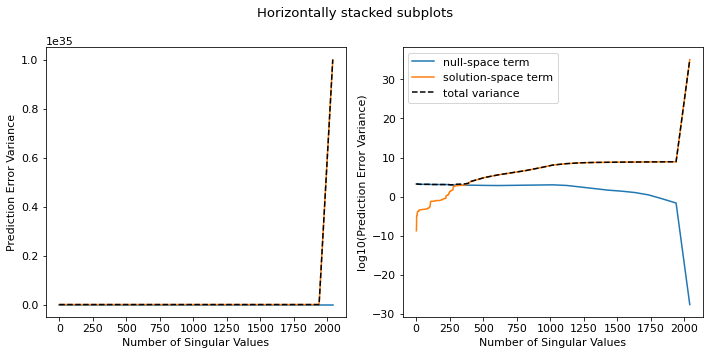

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Horizontally stacked subplots')
ax1.plot(predvar1_df.sing_val_index, predvar1_df.null_space_term)
ax1.plot(predvar1_df.sing_val_index, predvar1_df.soln_space_term)
ax1.plot(predvar1_df.sing_val_index, predvar1_df.tot_variance, linestyle='--', c='k')

ax2.plot(predvar1_df.sing_val_index, np.log10(predvar1_df.null_space_term), label='null-space term')
ax2.plot(predvar1_df.sing_val_index, np.log10(predvar1_df.soln_space_term), label='solution-space term')
ax2.plot(predvar1_df.sing_val_index, np.log10(predvar1_df.tot_variance), linestyle='--', c='k', label='total variance')

ax1.set(xlabel='Number of Singular Values', ylabel='Prediction Error Variance')
ax2.set(xlabel='Number of Singular Values', ylabel='log10(Prediction Error Variance)')

plt.legend()
plt.tight_layout()

In [98]:
# Singular value index for which minimum error variance occur
predvar1_df.loc[predvar1_df['tot_variance'] == predvar1_df.tot_variance.min()]

sing_val_index  null_space_term  soln_space_term  tot_variance  \
273           273.0         1023.738         57.90528      1081.643   

     tot_std_dev  
273     32.88834

### PREDUNC1

In [99]:
def get_predunc1_results(ws, filename):
    '''
    This function takes a GENLINPRED_ABBREV output file
    and returns the results of PREDUNC1: precalibration
    total uncertainty variance, precalibration total
    uncertainty standard deviation, postcalibration
    total uncertainty variance and postcalibration
    total uncertainty standard deviation.
    '''
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
        
    begin_predunc1_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC1 analysis for prediction' in w)
    end_predunc1_idx = begin_predunc1_idx + 9
    
    
    precal_tot_unc_var = float(outfile[end_predunc1_idx - 6].split()[-1])
    precal_tot_unc_stdev = float(outfile[end_predunc1_idx - 5].split()[-1])
    
    postcal_tot_unc_var = float(outfile[end_predunc1_idx - 2].split()[-1])
    postcal_tot_unc_stdev = float(outfile[end_predunc1_idx - 1].split()[-1])
    
    return precal_tot_unc_var, precal_tot_unc_stdev, postcal_tot_unc_var, postcal_tot_unc_stdev

In [100]:
precal_uncvar, precal_uncstdev, postcal_uncvar, postcal_uncstdev = get_predunc1_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [101]:
### Scenario: monthly output
#
# prediction lk70_1 = -2.623055
#
#
#
#
#
#
#
#
#

In [102]:
lk70_1 = -4.975987
lk140_1 = -17.21459
lk210_1 = -12.13656

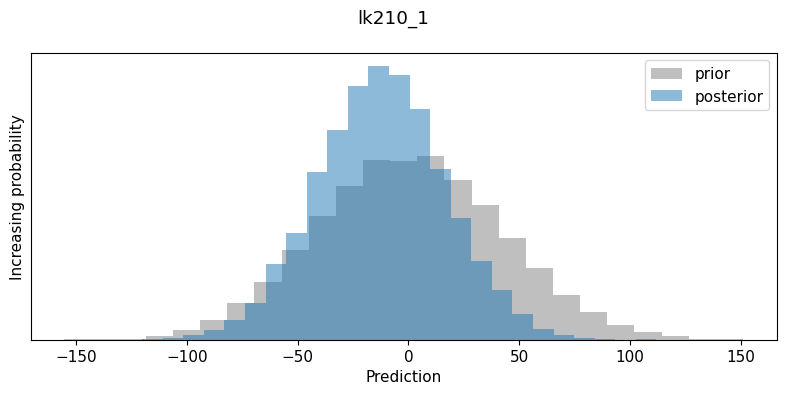

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)

fig.suptitle('lk210_1')

x_precal = np.random.normal(loc=0, scale=precal_uncstdev, size=10000)
x_postcal = np.random.normal(loc=lk210_1, scale=postcal_uncstdev, size=10000)

ax.hist(x_precal, bins=25, density=True, color='gray', alpha=0.5, label='prior')
ax.hist(x_postcal, bins=25, density=True, alpha=0.5, label='posterior')

ax.set(xlabel='Prediction', ylabel='Increasing probability')

ax.set_yticklabels([])
ax.set_yticks([])

plt.legend()
plt.tight_layout()

### PREDUNC4

In [104]:
def get_predunc4_results(ws, filename):
    
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()

    # Read file
    begin_predunc4_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC4 analysis for prediction' in w)
    begin_predunc5_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC5 observation subtraction analysis' in w)

    predunc4_cols = ['pargp', 'precal_contribution', 'postcal_contribution']
    predunc4_data = [i.split() for i in outfile[begin_predunc4_idx + 7 : begin_predunc5_idx - 2]]

    # Instantiate dataframe
    df = pd.DataFrame(predunc4_data, columns=predunc4_cols)
    
    
    # Convert data to float
    for col in ['precal_contribution', 'postcal_contribution']:
        df[col] = df[col].astype(float)

    return df

In [105]:
predunc4_df = get_predunc4_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

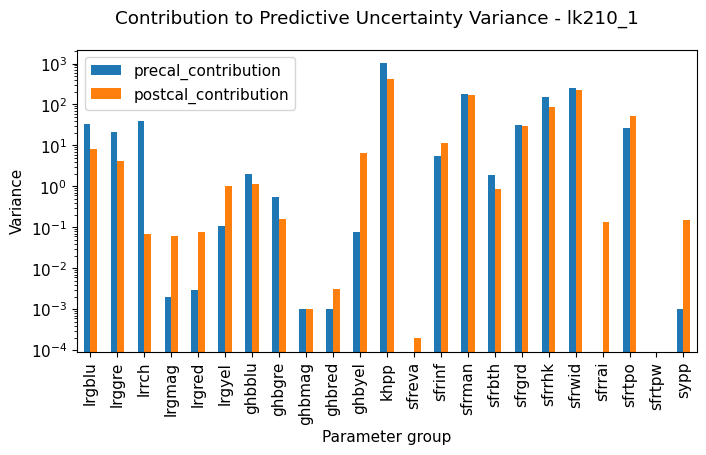

In [106]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
fig.suptitle('Contribution to Predictive Uncertainty Variance - lk210_1')
predunc4_df.plot.bar(x='pargp', ax=ax)
ax.set_yscale('log')

ax.set(xlabel='Parameter group', ylabel='Variance')

plt.show()

### PREDUNC5

In [107]:
def get_predunc5_results(ws, filename):
    
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
        
    # Read file
    begin_predunc5_subtract_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC5 observation subtraction analysis' in w)
    end_predunc5_subtract_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC5 observation addition analysis' in w) - 2

    predunc5_subtraction_cols = ['observation_group', 'variance_increase']
    predunc5_addition_cols = ['observation_group', 'variance_decrease']
    predunc5_subtraction_analysis = [i.split() for i in outfile[begin_predunc5_subtract_idx + 6:end_predunc5_subtract_idx]]
    predunc5_addition_analysis = [i.split() for i in outfile[end_predunc5_subtract_idx + 8:]]

    # Instantiate dataframe
    predunc5_subtract_df = pd.DataFrame(predunc5_subtraction_analysis, columns=predunc5_subtraction_cols)
    predunc5_addition_df = pd.DataFrame(predunc5_addition_analysis, columns=predunc5_addition_cols)

    df = pd.merge(predunc5_subtract_df, predunc5_addition_df)

    # Convert data to float
    for col in ['variance_increase', 'variance_decrease']:
        df[col] = df[col].astype(float)
    
    df = df[df.observation_group != 'pleak']
    
    return df

In [108]:
predunc5_df = get_predunc5_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [109]:
predunc5_df

observation_group  variance_increase  variance_decrease
0             heads             2.9169            381.638
1            stage1            51.5548            330.199
2             gage1            29.9342            164.554
3             gage2            17.0361            327.223
4         dh_hedstg             6.0206            438.142
5           heads_d            17.6340            277.579
6          stage1_d            14.3560             98.312
7           gage1_d             3.3131             53.599
8           gage2_d             2.3650            113.279

<ipython-input-110-1537e148f845>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(predunc5_df.observation_group, rotation=45, ha='right')


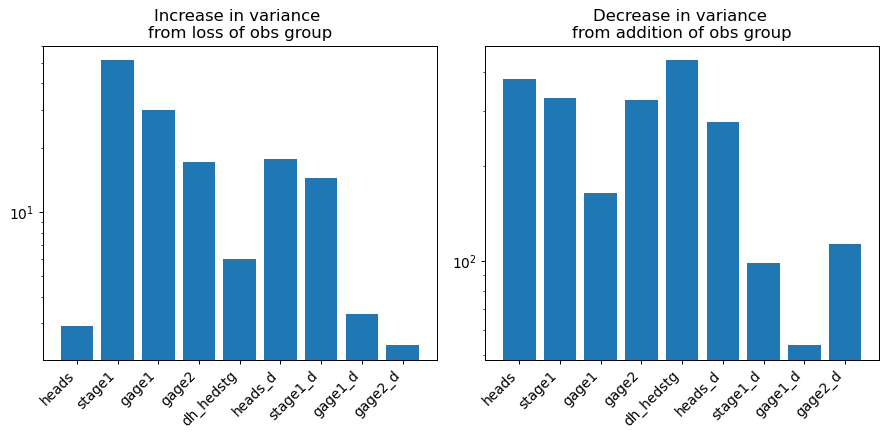

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=90)

ax1.bar(predunc5_df.observation_group, predunc5_df.variance_increase)

ax2.bar(predunc5_df.observation_group, predunc5_df.variance_decrease)

ax1.set_title('Increase in variance \nfrom loss of obs group')
ax2.set_title('Decrease in variance \nfrom addition of obs group')

for ax in [ax1, ax2]:
    ax.set_yscale('log')
    ax.set_xticklabels(predunc5_df.observation_group, rotation=45, ha='right')

plt.tight_layout()

plt.show()

### Visualize parameter uncertainty reduction

In [295]:
shutil.copy(os.path.join(pest_ws, 'calib1-wt-cov-linux.par.10'), os.path.join(pest_ws, 'reluncred.par'))

'..\\2022_01_22_ok_1week_out\\pest\\reluncred.par'

Replace parameters in reluncred.par with relative variance uncertainty reduction:

In [303]:
with open(os.path.join(pest_ws, 'reluncred.par'), 'r') as file:
    pruvrfile = file.readlines()

In [304]:
reluncred_cols = ['parameter', 'parval1', 'scale', 'offset']
reluncred_data = [i.split() for i in pruvrfile[1:]]

reluncred_df = pd.DataFrame(reluncred_data, columns=reluncred_cols)

Replace parameter values with results from supcalc.

Create a new column in reluncred_df:

In [305]:
reluncred_df['rel_uncert_var_redn'] = reluncred_df['parameter'].map(supcalc_res.set_index('parameter')['rel_uncert_var_redn'])

Replace NaN with 0 (fixed parameters):

In [306]:
reluncred_df.loc[reluncred_df['rel_uncert_var_redn'].isna(), 'rel_uncert_var_redn'] = 0

Replace 0 values with 1e-10 (PEST wont allow log transform of 0)

In [307]:
reluncred_df.loc[reluncred_df.rel_uncert_var_redn == 0, 'rel_uncert_var_redn'] = 1e-10

Replace column values and drop column:

In [308]:
reluncred_df['parval1'] = reluncred_df['rel_uncert_var_redn']

In [310]:
reluncred_df.drop('rel_uncert_var_redn', axis=1, inplace=True)

Extract to list:

In [311]:
reluncred_df.offset = [i+'\n' for i in reluncred_df.offset]

In [312]:
pardata_list = reluncred_df.values.tolist()

In [313]:
pardata_new = []
for i in pardata_list:
    pardata_new.append(' '.join(str(v) for v in i))

Replace data:

In [314]:
pruvrfile[1:] = pardata_new

In [315]:
with open(os.path.join(pest_ws, 'reluncred.par'), 'w') as file:
    for line in pruvrfile:
        file.write(line)

In [316]:
p = subprocess.run([
    'parrep',
    'reluncred.par',
    'linunc.pst',
    'linunc-red.pst',
    '0'
], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)


PARREP Version 17.3. Watermark Numerical Computing.

Reading parameter value file reluncred.par ----->
Data for 2065 parameters read from file reluncred.par.

Reading file linunc.pst and writing file linunc-red.pst ----->
File linunc-red.pst written ok.



In [257]:
write_script(os.path.join(pest_ws, 'start_manager_uncred.bat'), [
f'''
set PATH=%PATH%;{bins_abspth}
pest_hp_mkl linunc-red.pst /h :4004
pause
'''
])

In [258]:
write_script(os.path.join(agent_pest_ws, 'start_agent_uncred.bat'), [
f'''
set PATH=%PATH%;{bins_abspth}
agent_hp linunc-red.pst /h %computername%:4004
pause
'''
])

In [317]:
shutil.copy(os.path.join(pest_ws, 'linunc-red.pst'), os.path.join(agent_pest_ws, 'linunc-red.pst'))

'..\\2022_01_22_ok_1week_out\\agent\\pest\\linunc-red.pst'

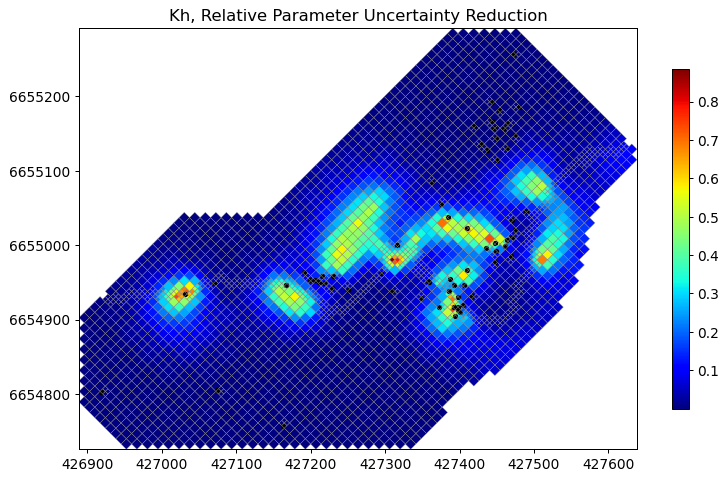

In [321]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25)
gwf_agent.npf.k.plot(masked_values=[0.0], colorbar=True, cmap="jet")    

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=10, label=f'{category} measurements', c='k')

plt.title('Kh, Relative Parameter Uncertainty Reduction')
plt.show()

In [ ]:
def expand_diff( arr, delta ):
    diff = np.diff( arr, prepend = 0.0 )
    diff[1:] += np.sign( diff[1:] ) * delta
    new_arr = diff.cumsum()
    return new_arr + arr.mean() - new_arr.mean()

In [ ]:
flaxoro = np.array([10.0, 8.0, 7.9])

In [ ]:
expand_diff(flaxoro, 0.1)

In [ ]:
expand_diff(flaxoro, -0.1)

In [ ]:
floxoro = np.array([10.0, 8.0, 7.9, 7.8])

In [ ]:
expand_diff(floxoro, 0.1)

In [ ]:
expand_diff(floxoro, -0.1)

In [ ]:
arr = np.array([10.0,6.5,3.0,1.3])
stretch = 0.1

d = np.arange(-len(arr),0,-1) * stretch
d = d - np.mean(d)

arr += d

In [ ]:
sns.__version__